# SECOM Yield Prediction — End-to-End Notebook

**Goal:** Predict *Fail* outcomes from process measurements to reduce scrap and downtime.

**Data:** `data/secom.data`, `data/secom_labels.data`, `data/secom.names` (UCI ML Repository, real fab data).

**Primary metric:** Recall on *Fail* at acceptable precision. Report PR-AUC and Balanced Error Rate (BER).

> Safety: No unsupported claims. Treat outputs as decision support, not automation.

## **Executive Summary**  
### This project applies machine learning to the SECOM semiconductor manufacturing dataset (590 sensor readings, 1,567 runs) to predict wafer failures. The dataset is highly imbalanced (≈6.6% fails). Logistic Regression and MLP provide the strongest baselines (PR-AUC ≈0.17), while tree-based models underperform. Dimensionality reduction (PCA) reduced accuracy, highlighting the challenge of rare-event prediction in high-dimensional, noisy process data.

## Dataset Information
```
Additional Information

A complex modern semi-conductor manufacturing process is normally under consistent surveillance via the monitoring of signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. It is often the case that useful information is buried in the latter two. Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs.

To enhance current business improvement techniques the application of feature selection as an intelligent systems technique is being investigated.

The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing, figure 2, and associated date time stamp. Where –1 corresponds to a pass and 1 corresponds to a fail and the data time stamp is for that specific test point.


Using feature selection techniques it is desired to rank features according to their impact on the overall yield for the product, causal relationships may also be considered with a view to identifying the key features.

Results may be submitted in terms of feature relevance for predictability using error rates as our evaluation metrics. It is suggested that cross validation be applied to generate these results. Some baseline results are shown below for basic feature selection techniques using a simple kernel ridge classifier and 10 fold cross validation.

Baseline Results: Pre-processing objects were applied to the dataset simply to standardize the data and remove the constant features and then a number of different feature selection objects selecting 40 highest ranked features were applied with a simple classifier to achieve some initial results. 10 fold cross validation was used and the balanced error rate (*BER) generated as our initial performance metric to help investigate this dataset.


SECOM Dataset: 1567 examples 591 features, 104 fails

FSmethod (40 features) BER % True + % True - %
S2N (signal to noise) 34.5 +-2.6 57.8 +-5.3 73.1 +2.1
Ttest 33.7 +-2.1 59.6 +-4.7 73.0 +-1.8
Relief 40.1 +-2.8 48.3 +-5.9 71.6 +-3.2
Pearson 34.1 +-2.0 57.4 +-4.3 74.4 +-4.9
Ftest 33.5 +-2.2 59.1 +-4.8 73.8 +-1.8
Gram Schmidt 35.6 +-2.4 51.2 +-11.8 77.5 +-2.3

Has Missing Values?

Yes
```

### 1. Setup

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


# Global style for plots
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False,
    "figure.dpi": 300,
    "legend.frameon": True,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.fontsize": 12
})

# Apply to seaborn
sns.set_theme(context="notebook", style="ticks")

# Reproducibility
rnd_num = 42
np.random.seed(rnd_num)

# Data directory
DATA_DIR = Path("../data")
RAW = DATA_DIR
assert (RAW/"secom.data").exists() and (RAW/"secom_labels.data").exists(), "Data files are missong!"

# Results directory
RESULT_DIR = Path("../results")
RESULT_DIR.mkdir(exist_ok=True, parents=True)

### 2. Helper functions

In [2]:
def annotate_countplot(
    ax, summary, label_map={0:"Pass", 1:"Fail"},
    offset_frac=0.001, position="top"
):
    """
    Annotate bars in a countplot with count and percentage.
    
    Parameters
    ----------
    ax : matplotlib Axes
        The countplot axes object.
    summary : DataFrame
        DataFrame with Count and Percentage indexed by label names.
    label_map : dict
        Maps tick index (0,1,...) to label names in summary.
    offset_frac : float
        Fraction of bar height/axis to offset text.
    position : {"top","center","bottom"}
        Where to place annotation relative to bar.
    """
    heights = [p.get_height() for p in ax.patches if p.get_height() > 0]
    if not heights:
        return
    offset = max(heights) * offset_frac

    for p in ax.patches:
        h = p.get_height()
        if h <= 0:   # skip zero-height bars from hue
            continue

        x = p.get_x() + p.get_width()/2.0
        cls_idx = int(round(x))  
        cls_name = label_map.get(cls_idx, str(cls_idx))

        cnt = summary.loc[cls_name, "Count"]
        pct = summary.loc[cls_name, "Percentage"]

        # y-position depending on user choice
        if position == "top":
            y = h + offset
            va = "bottom"
        elif position == "center":
            y = h/2
            va = "center"
        elif position == "bottom":
            y = offset
            va = "bottom"
        else:
            raise ValueError("position must be 'top','center', or 'bottom'")

        ax.annotate(f"{cnt} ({pct:.1f}%)", (x, y),
                    ha="center", va=va, fontsize=11)

### 3. Load and Audit.

#### 3.1. Load features and lables

**Key facts:** Data Structure: The data consists of 2 files the dataset file SECOM consisting of 1567 examples each with 590 features a 1567 x 590 matrix and a labels file containing the classifications and date time stamp for each example. The data is represented in a raw text file each line representing an individual example and the features seperated by spaces. The null values are represented by the 'NaN' value as per MatLab. 

In [3]:
# Quick look at the data features count per row.
p = Path(str(RAW/"secom.data"))
with p.open() as f:
    counts = [len(line.split()) for line in f]

print("min/max fields per row:", min(counts), max(counts))

min/max fields per row: 590 590


In [4]:
# Load the train data.
# Features: 590 columns, whitespace-separated, 'NaN' denotes missing
data_X = pd.read_csv(RAW/"secom.data", header=None, sep="\s+", na_values=["NaN"], engine="python")
data_X.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [5]:
# Audit the data structure.
print("Shape:", data_X.shape)
print("\n--- X info ---"); data_X.info()
print("\nMissing fraction across features:"); display(data_X.isna().mean().describe())

Shape: (1567, 590)

--- X info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 590 entries, 0 to 589
dtypes: float64(590)
memory usage: 7.1 MB

Missing fraction across features:


count    590.000000
mean       0.045375
std        0.154340
min        0.000000
25%        0.001276
50%        0.003829
75%        0.005743
max        0.911934
dtype: float64

In [6]:
# Labels: two columns (label, timestamp)
data_y = pd.read_csv(RAW/"secom_labels.data", sep=r"\s+", header=None, names=["label","timestamp"])
data_y.head()

,label,timestamp
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [7]:
# Audit the data structure.
print("Shape:", data_y.shape)
print("\n--- X info ---"); data_y.info()

Shape: (1567, 2)

--- X info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      1567 non-null   int64 
 1   timestamp  1567 non-null   object
dtypes: int64(1), object(1)
memory usage: 24.6+ KB


In [8]:
# Convert timestap to datetime.
data_y["timestamp"] = pd.to_datetime(data_y["timestamp"], format="%d/%m/%Y %H:%M:%S", errors="raise")
data_y.head()

,label,timestamp
0,-1,2008-07-19 11:55:00
1,-1,2008-07-19 12:32:00
2,1,2008-07-19 13:17:00
3,-1,2008-07-19 14:43:00
4,-1,2008-07-19 15:22:00


In [9]:
data_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   label      1567 non-null   int64         
 1   timestamp  1567 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 24.6 KB


#### 3.2. Sanity check and merge the data.

In [10]:
assert len(data_X) == len(data_y), "Row count mismatch"
assert data_y["timestamp"].notna().all(), "Bad timestamps found"

In [11]:
df = data_X.copy()
df.columns = [f"f{i:03d}" for i in range(data_X.shape[1])]

In [12]:
df.columns

Index(['f000', 'f001', 'f002', 'f003', 'f004', 'f005', 'f006', 'f007', 'f008',
       'f009',
       ...
       'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588',
       'f589'],
      dtype='object', length=590)

In [13]:
df["label"] = data_y["label"].to_numpy()
df["timestamp"] = data_y["timestamp"].to_numpy()

In [14]:
df.head()

,f000,f001,f002,f003,f004,f005,f006,f007,f008,f009,...,f582,f583,f584,f585,f586,f587,f588,f589,label,timestamp
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 15:22:00


In [15]:
df.shape

(1567, 592)

### 4. Exploratory Data Analysis

#### 4.1. Map labels and check imbalance

In [16]:
# Map labels to 0/1. -1 -> 0 (normal), 1 -> 1 (abnormal)
df["label"] = df["label"].map({-1:0, 1:1}).astype(int)
df.head()

,f000,f001,f002,f003,f004,f005,f006,f007,f008,f009,...,f582,f583,f584,f585,f586,f587,f588,f589,label,timestamp
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 15:22:00


In [17]:
# Sort chronologically to avoid leakage later
df = df.sort_values("timestamp").reset_index(drop=True)

In [18]:
# Raw counts
counts = df["label"].value_counts().sort_index()

# Percentages
percentages = df["label"].value_counts(normalize=True).sort_index() * 100

# Combine into one table
summary = pd.DataFrame({
    "Count": counts,
    "Percentage": percentages.round(2)
}).rename(index={0:"Pass", 1:"Fail"})

print(summary)

       Count  Percentage
label                   
Pass    1463       93.36
Fail     104        6.64


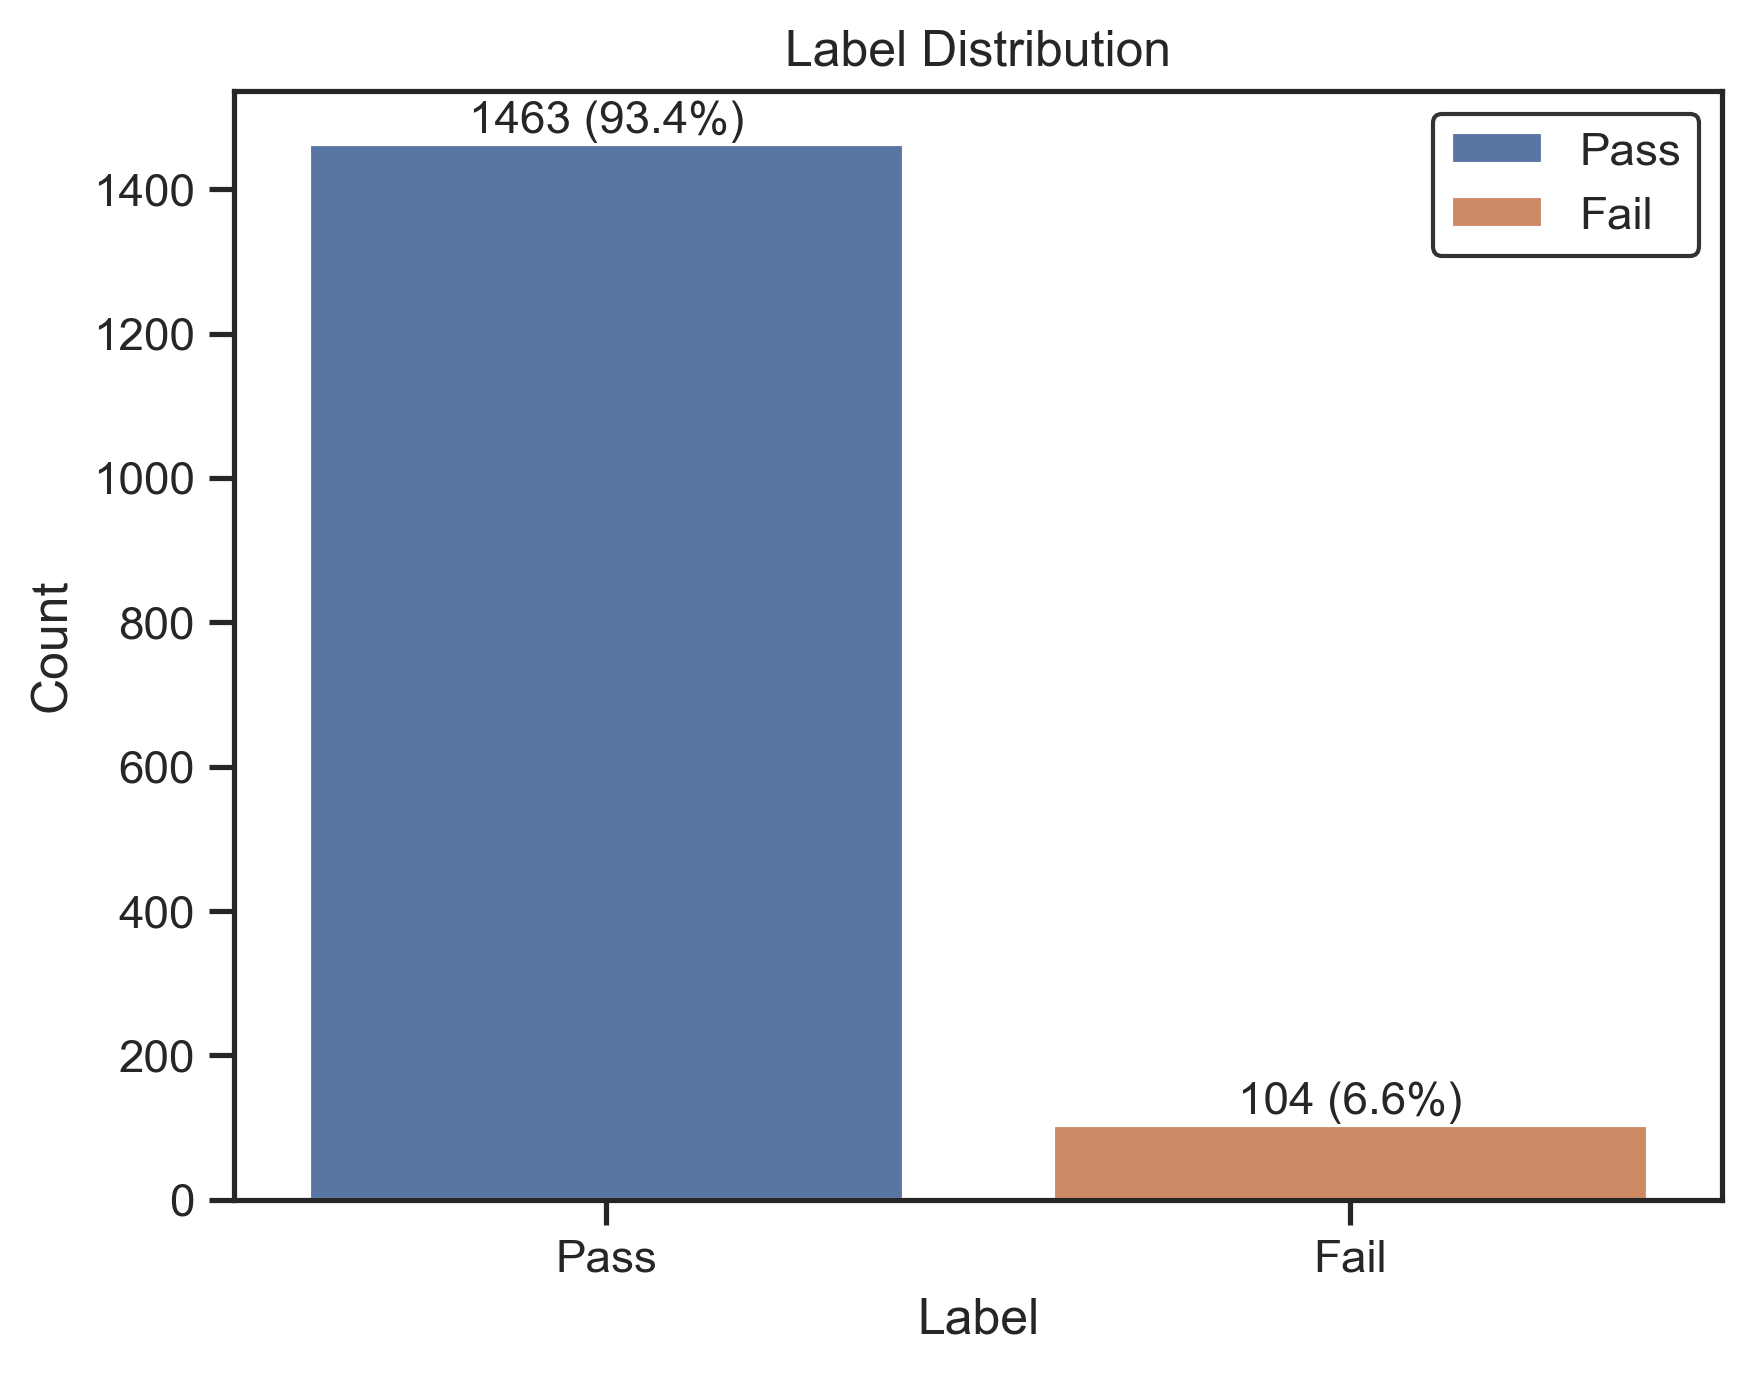

In [19]:
# Countplot
ax = sns.countplot(x="label", data=df, hue="label", legend=True)

ax.set_title("Label Distribution")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels(["Pass", "Fail"])
ax.legend(title=None, labels=['Pass', 'Fail'])
annotate_countplot(ax, summary, position='top')

plt.show()

#### Figure 1: Label Distribution.
> - The dataset is highly imbalanced, with `1,463` production runs `(93.4%)` labeled as `“Pass”` and only `104` runs `(6.6%)` labeled as `“Fail"`.
> - This imbalance highlights a key challenge in predictive modeling: naive classifiers could achieve high accuracy by predicting only the majority class `(Pass)`, but such models would completely miss the minority class `(Fail)`, which is of primary interest for yield prediction.
> - Consequently, specialized techniques such as `class-weighted loss functions`, `anomaly detection`, or `resampling` strategies are required to handle this skewed distribution effectively.

#### 4.2. Missing value analysis.

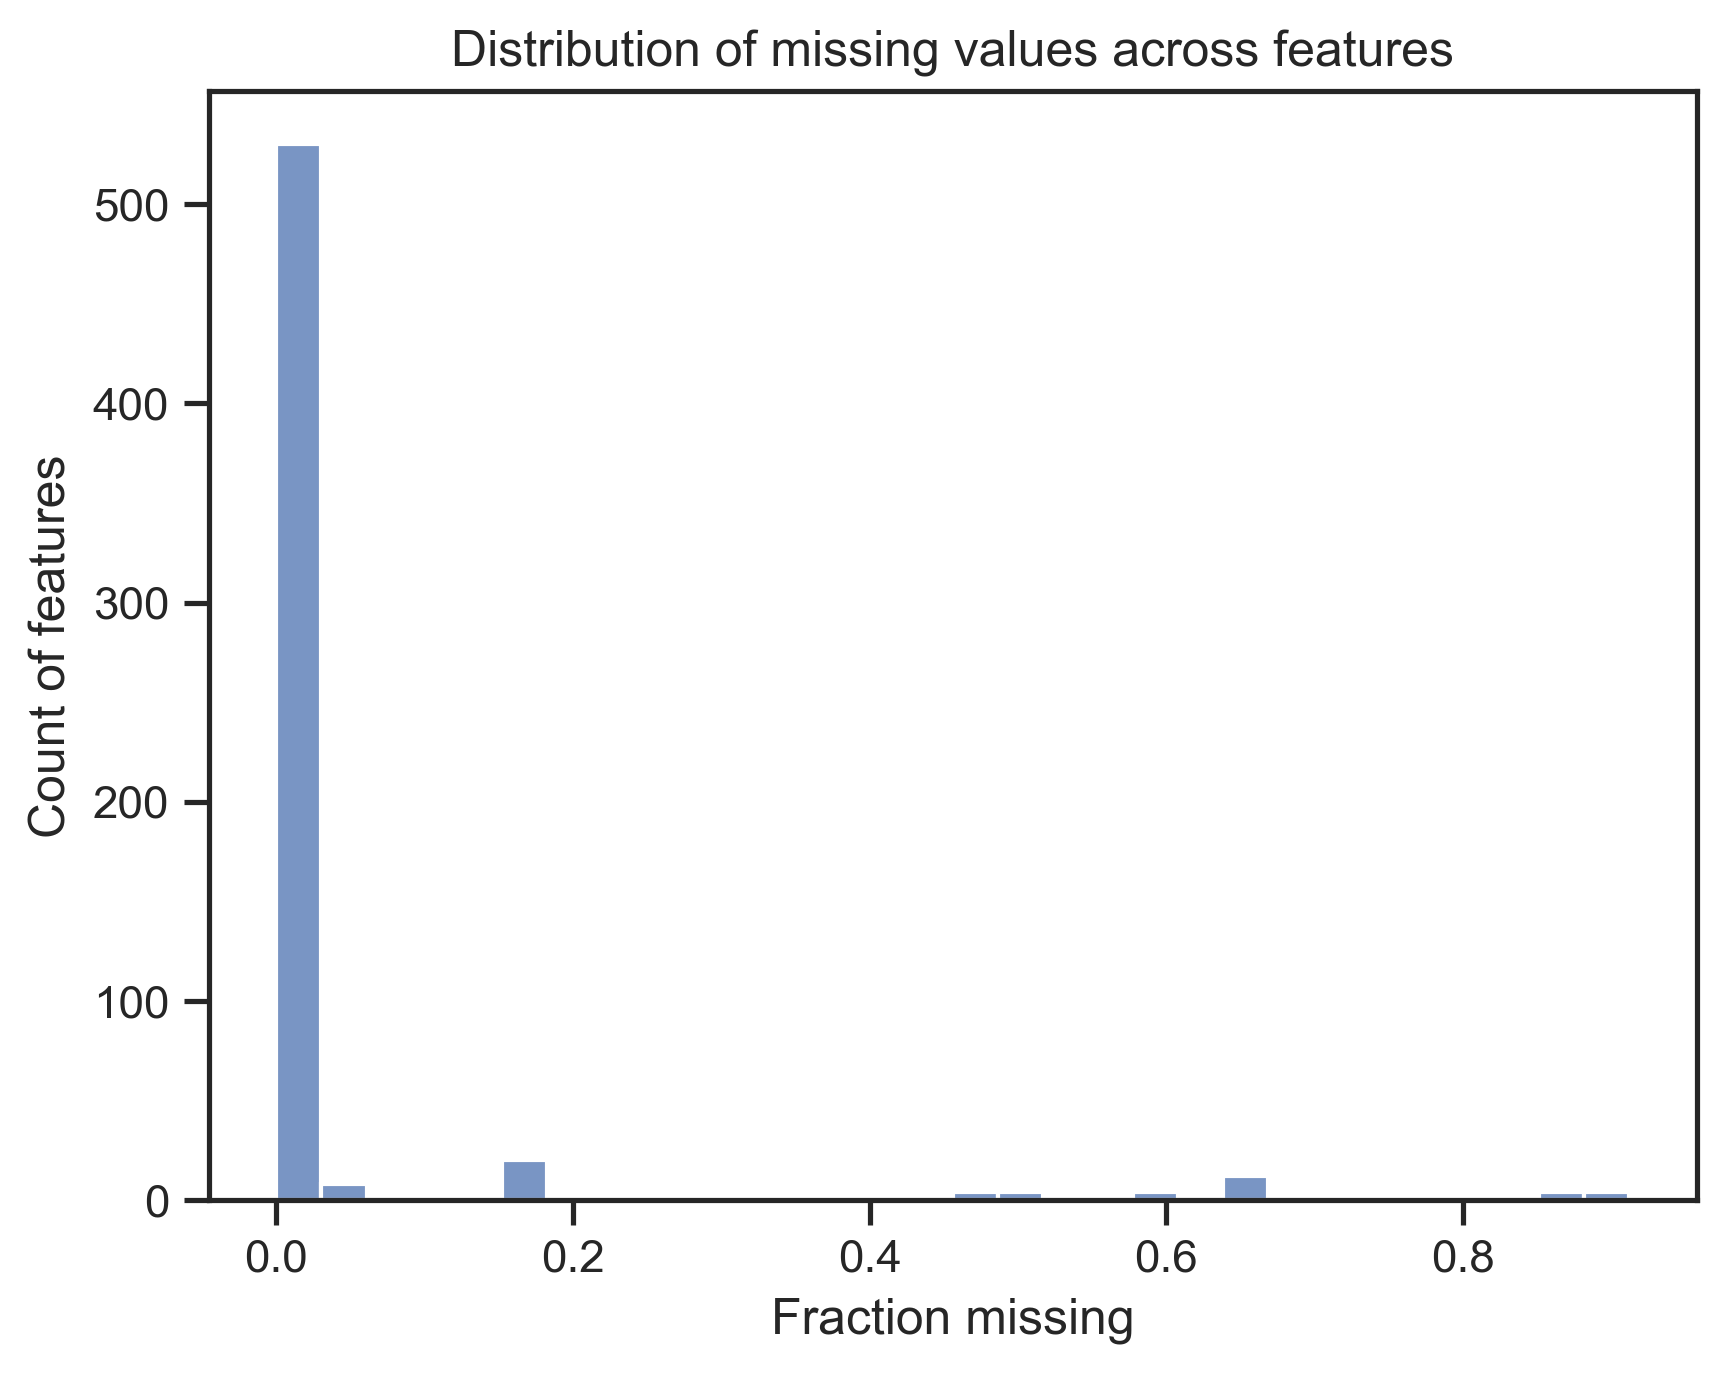

count    590.000000
mean       0.045375
std        0.154340
min        0.000000
25%        0.001276
50%        0.003829
75%        0.005743
max        0.911934
dtype: float64


In [20]:
# Fraction of missing per feature
missing_frac = df.drop(columns=["label", "timestamp"]).isna().mean()

sns.histplot(missing_frac, bins=30)
plt.xlabel("Fraction missing")
plt.ylabel("Count of features")
plt.title("Distribution of missing values across features")
plt.show()

print(missing_frac.describe())

#### Figure 2: Distribution of missing values across features in the SECOM dataset.
- Most of the 590 process-control features are nearly complete, with over 75% of features having less than 0.6% missing values. However, a small subset of features exhibits extreme sparsity — the worst feature is missing about 91% of its values. The average missing fraction across all features is ~4.5%.

- This pattern indicates that while most sensor readings can be imputed without significant information loss, a few features are unreliable and may need to be dropped or carefully handled. Such skewed missingness is common in industrial sensor datasets, where certain sensors fail intermittently or are only active in specific process steps.

### 4.3. Feature distributions (compare Pass vs Fail)

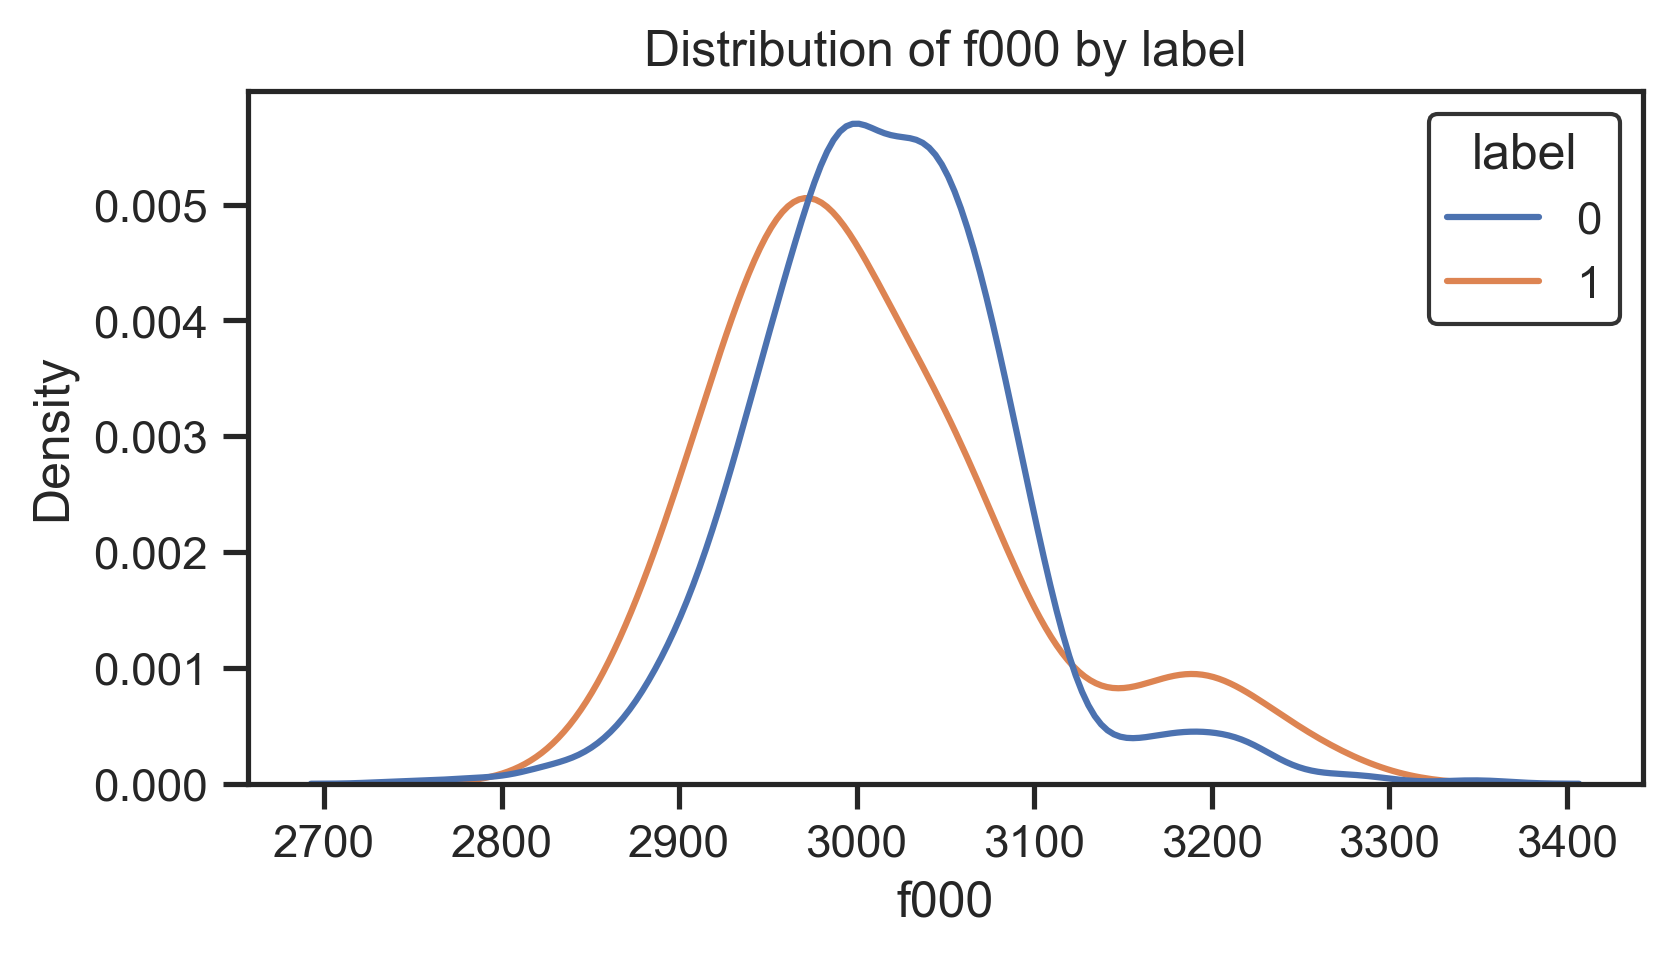

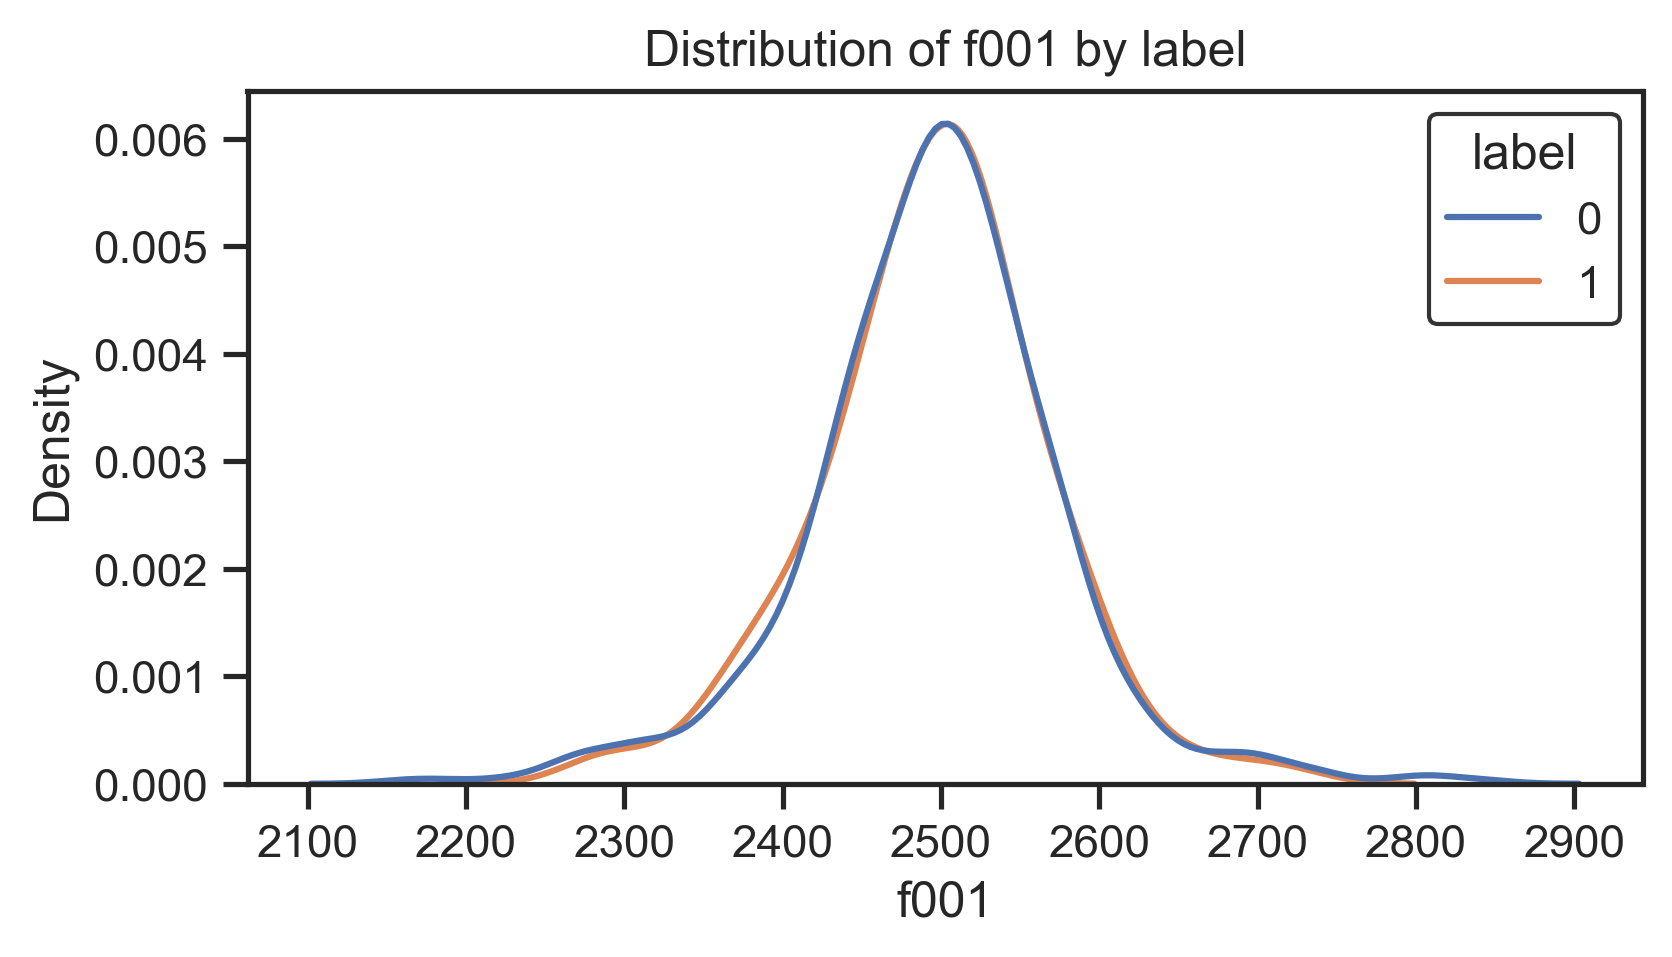

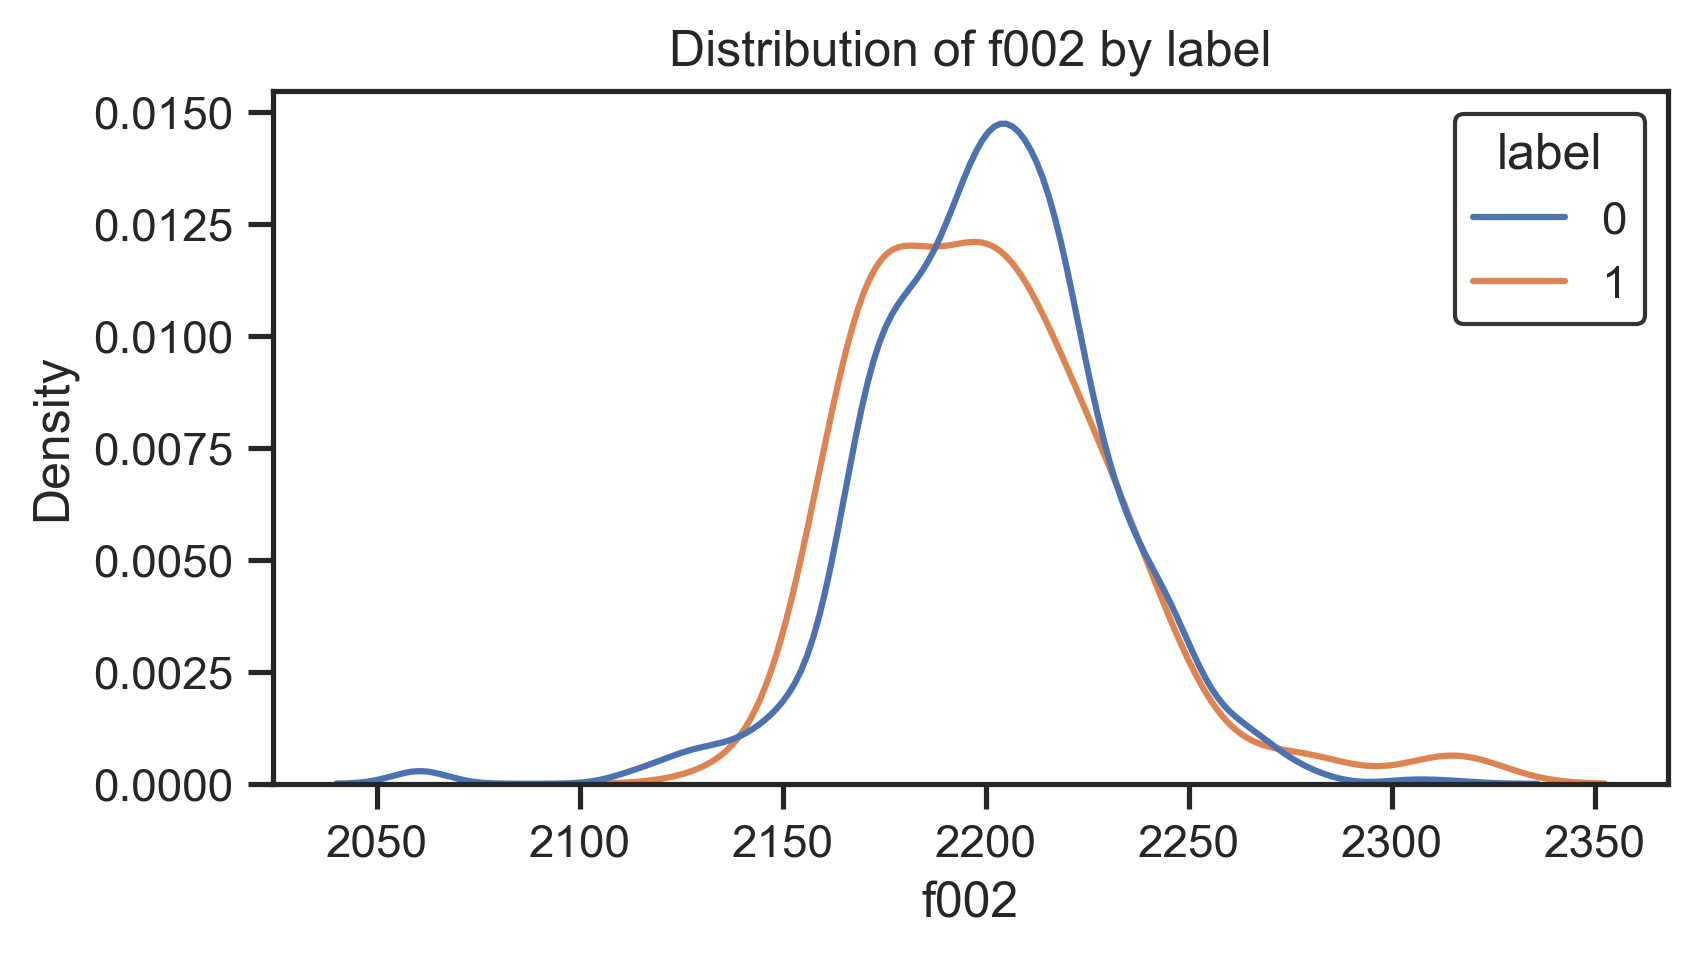

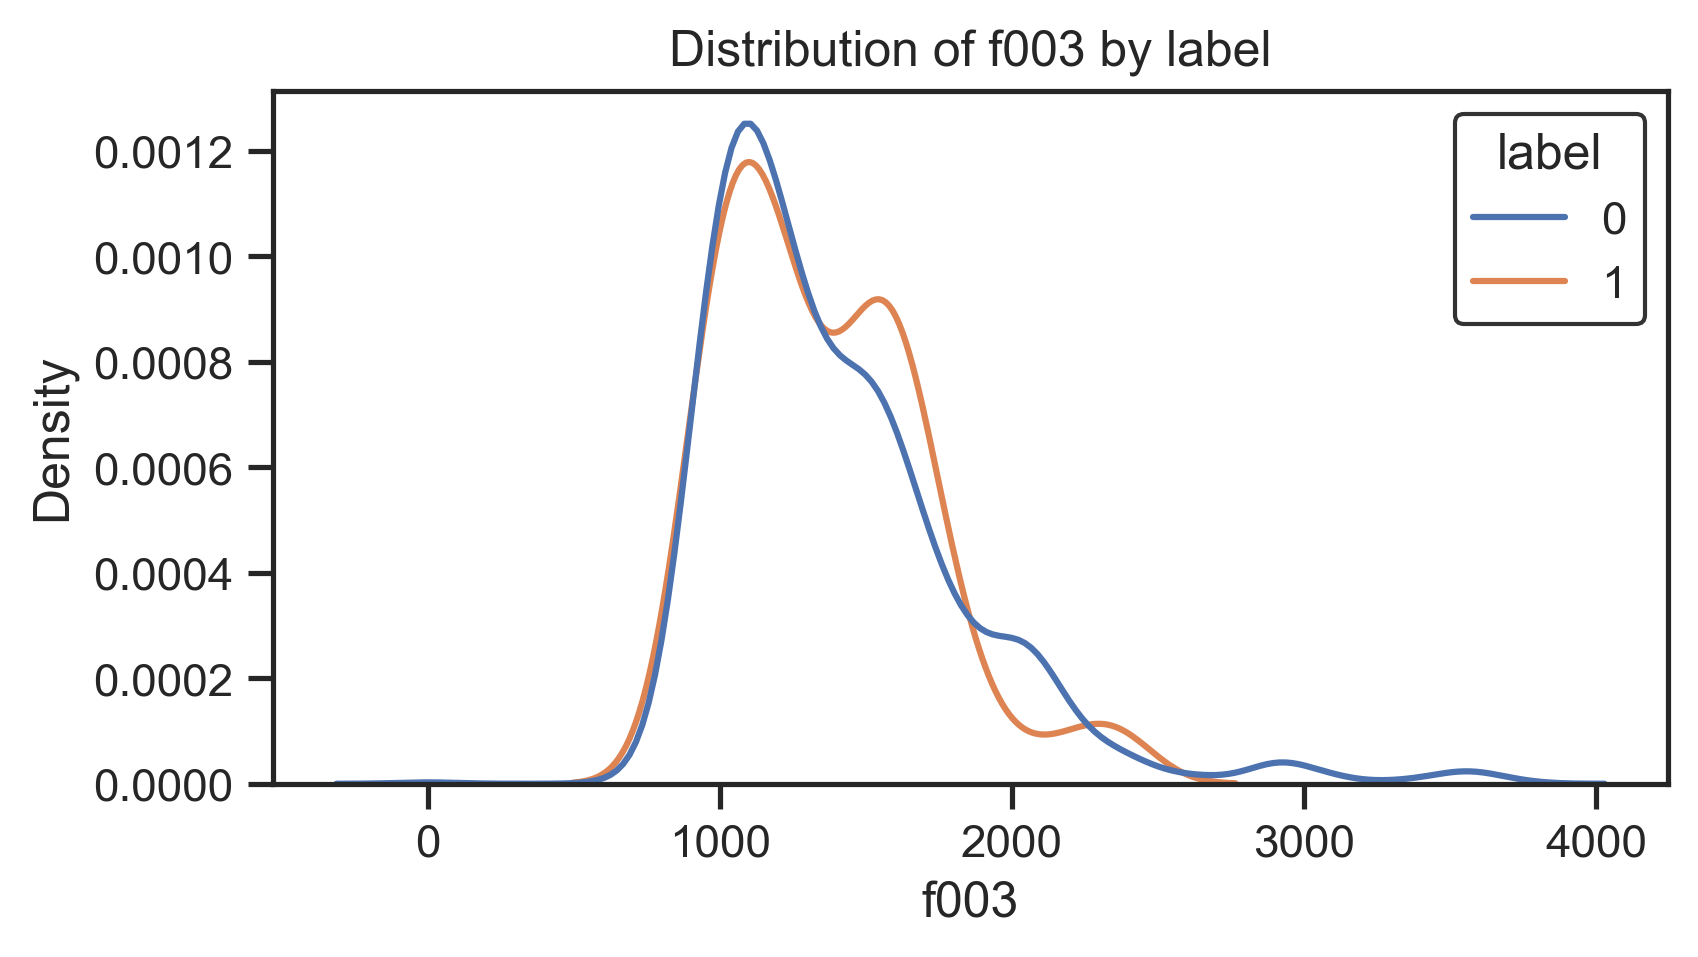

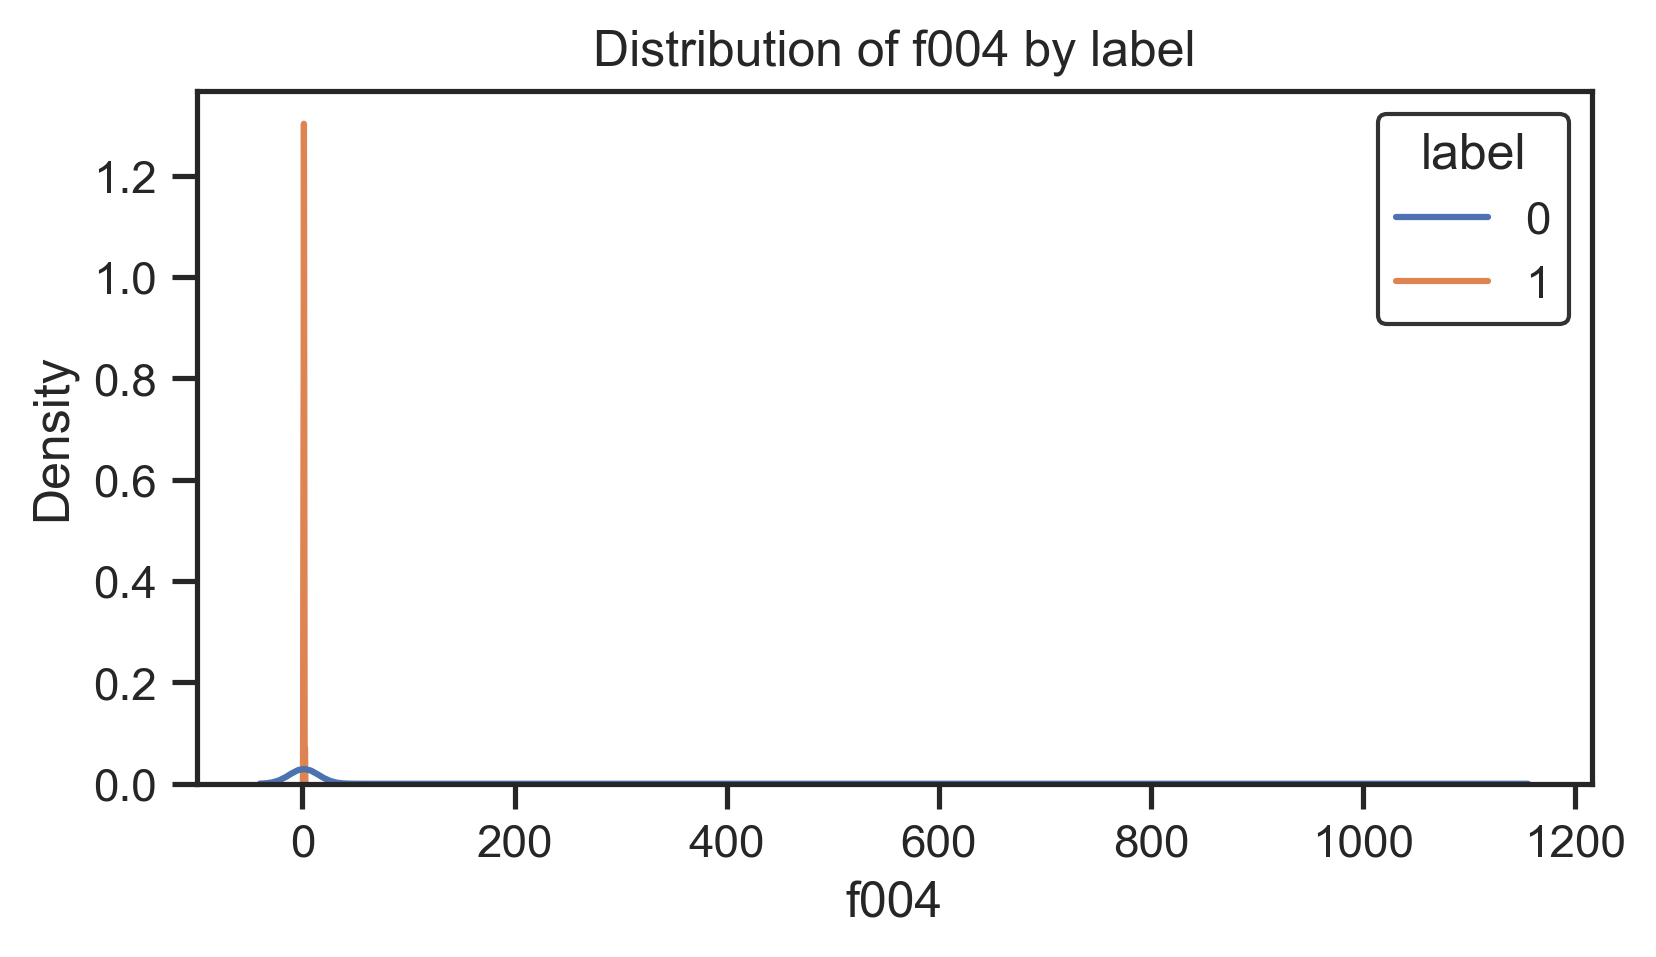

In [21]:
sample_cols = df.columns[:5]  # replace with random.sample(list(df.columns[:-1]), 5)

for col in sample_cols:
    plt.figure(figsize=(6,3))
    sns.kdeplot(data=df, x=col, hue="label", common_norm=False)
    plt.title(f"Distribution of {col} by label")
    plt.show()

#### **Insight:**
- Features like f000, f002, f003 show small but visible separation --> potentially informative.
- Features like f001 are redundant (no signal).
- Features like f004 are suspicious (could be constant, zero-heavy, or proxy for missingness).

>Why EDA on distributions is crucial: it shows which features may carry label signal, which are noise, and which may just be artifacts.

### 4.4. Outlier detection per feature (boxplots)

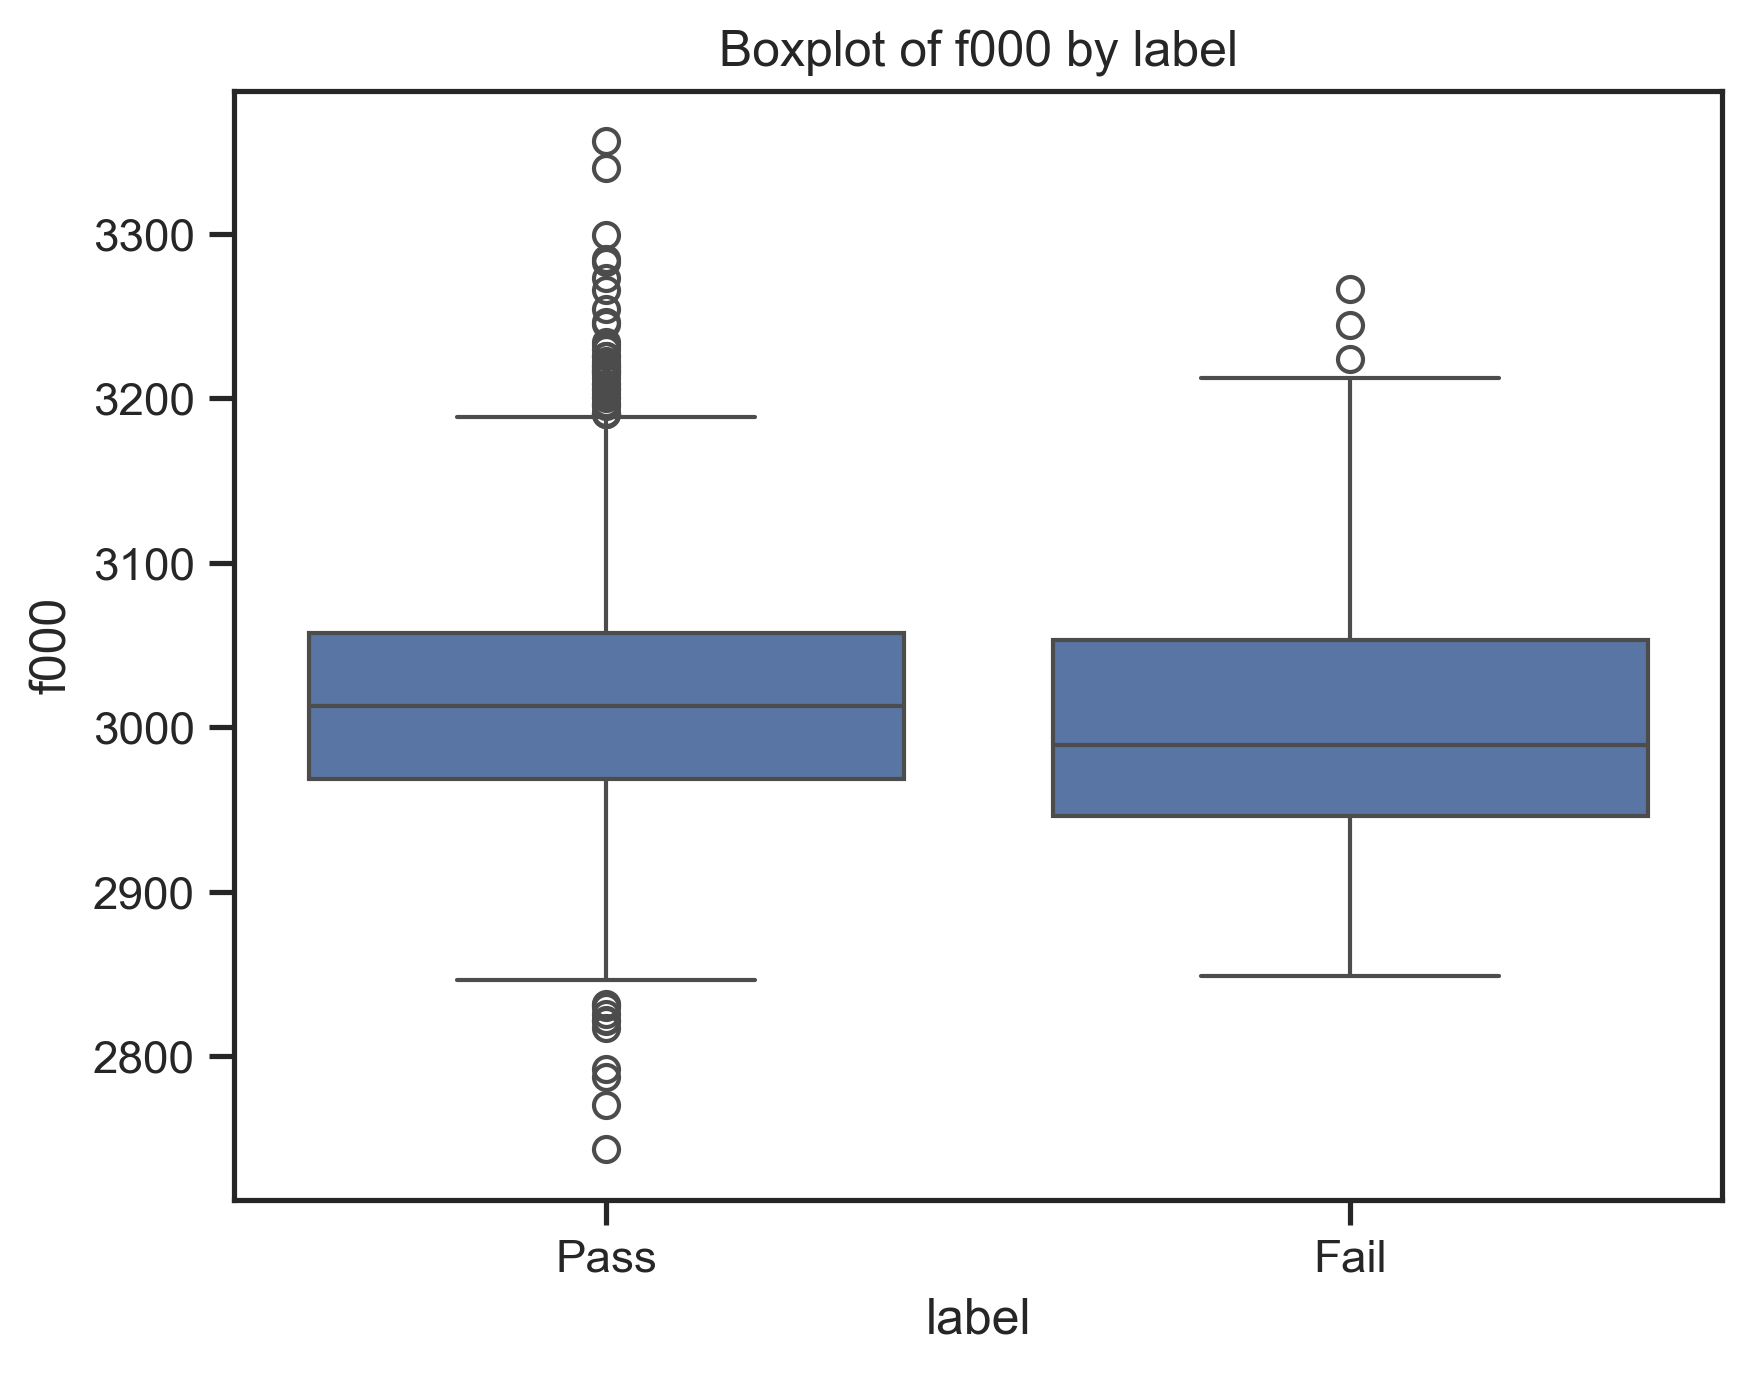

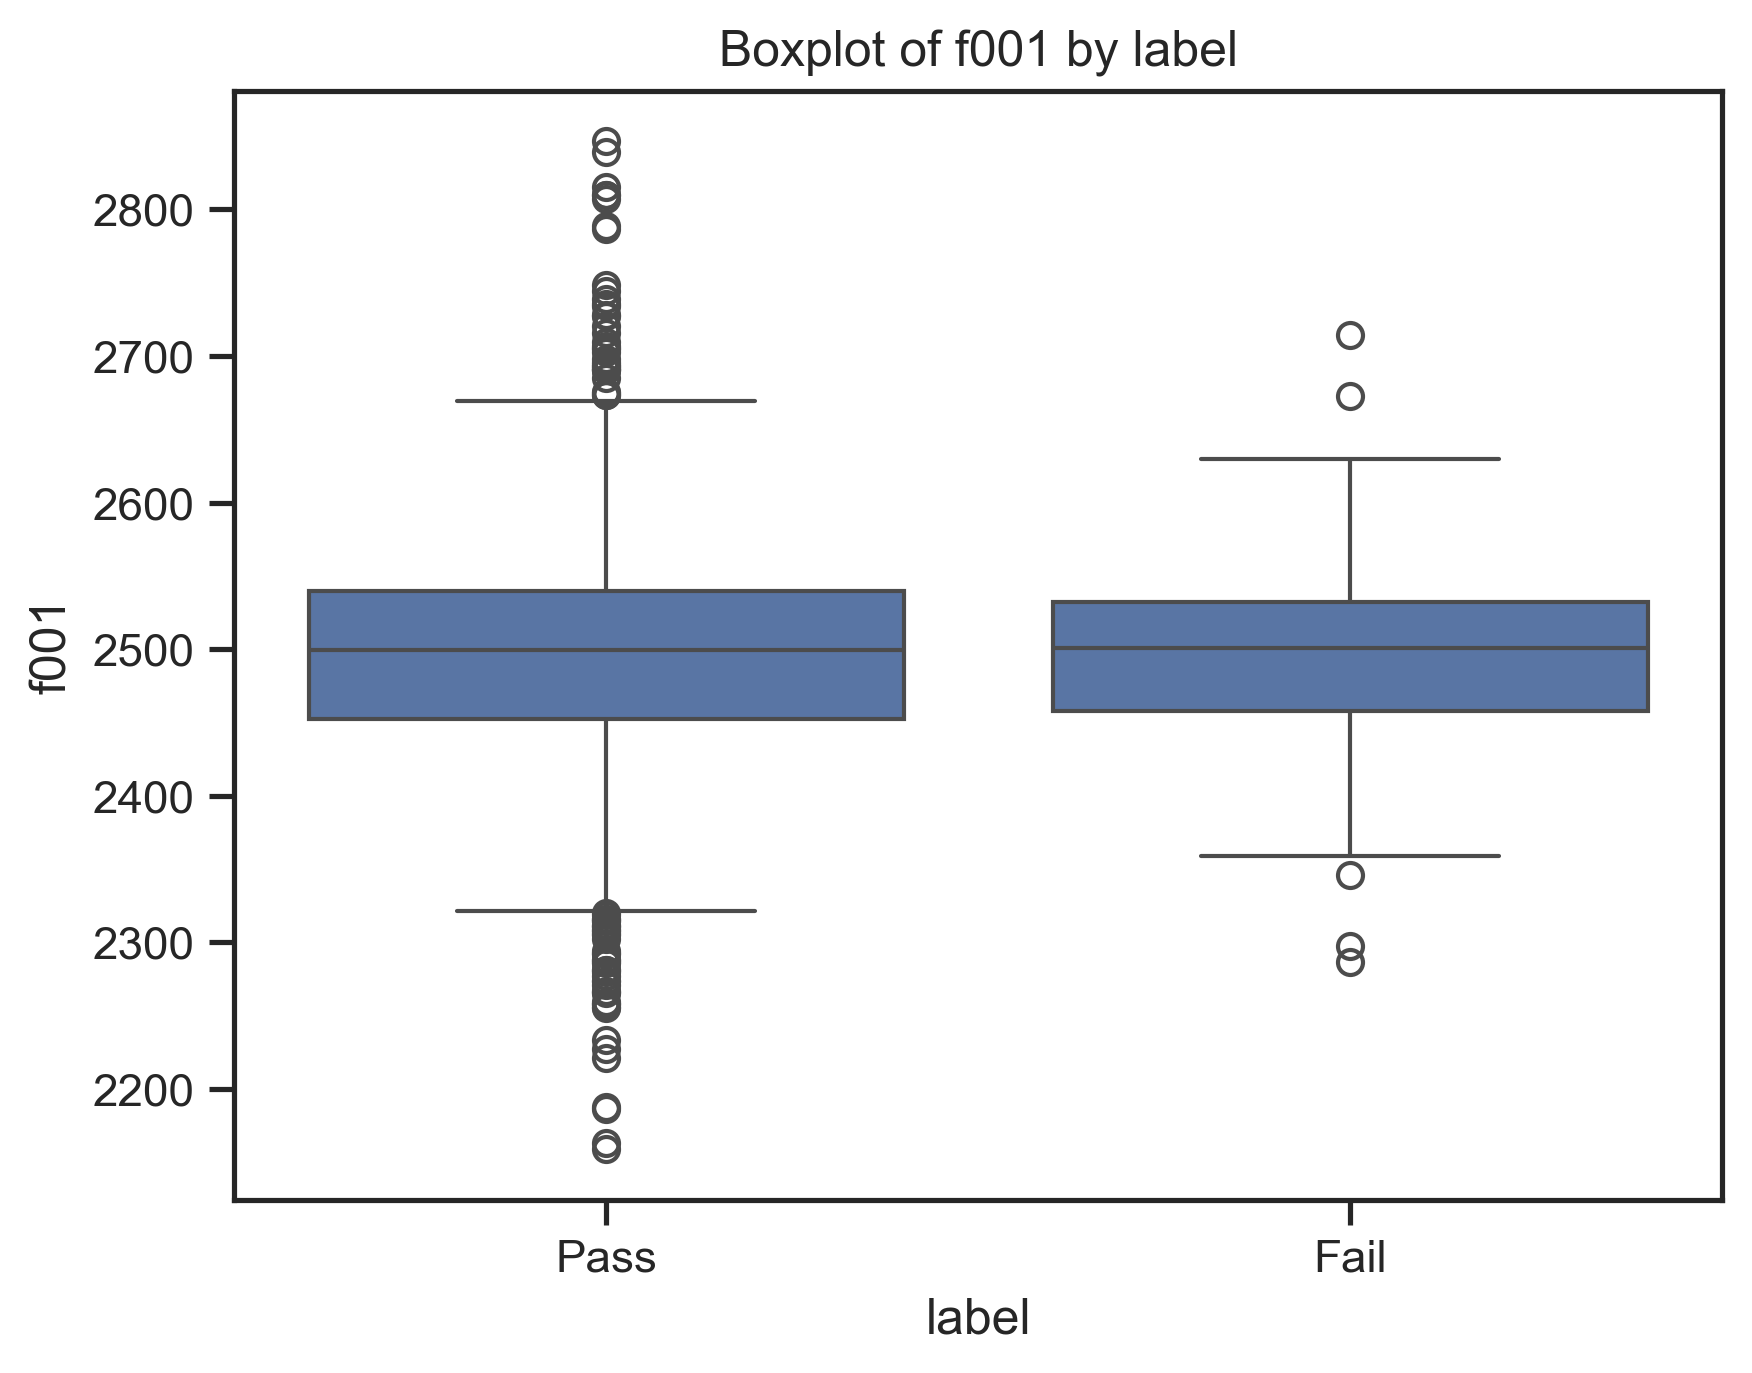

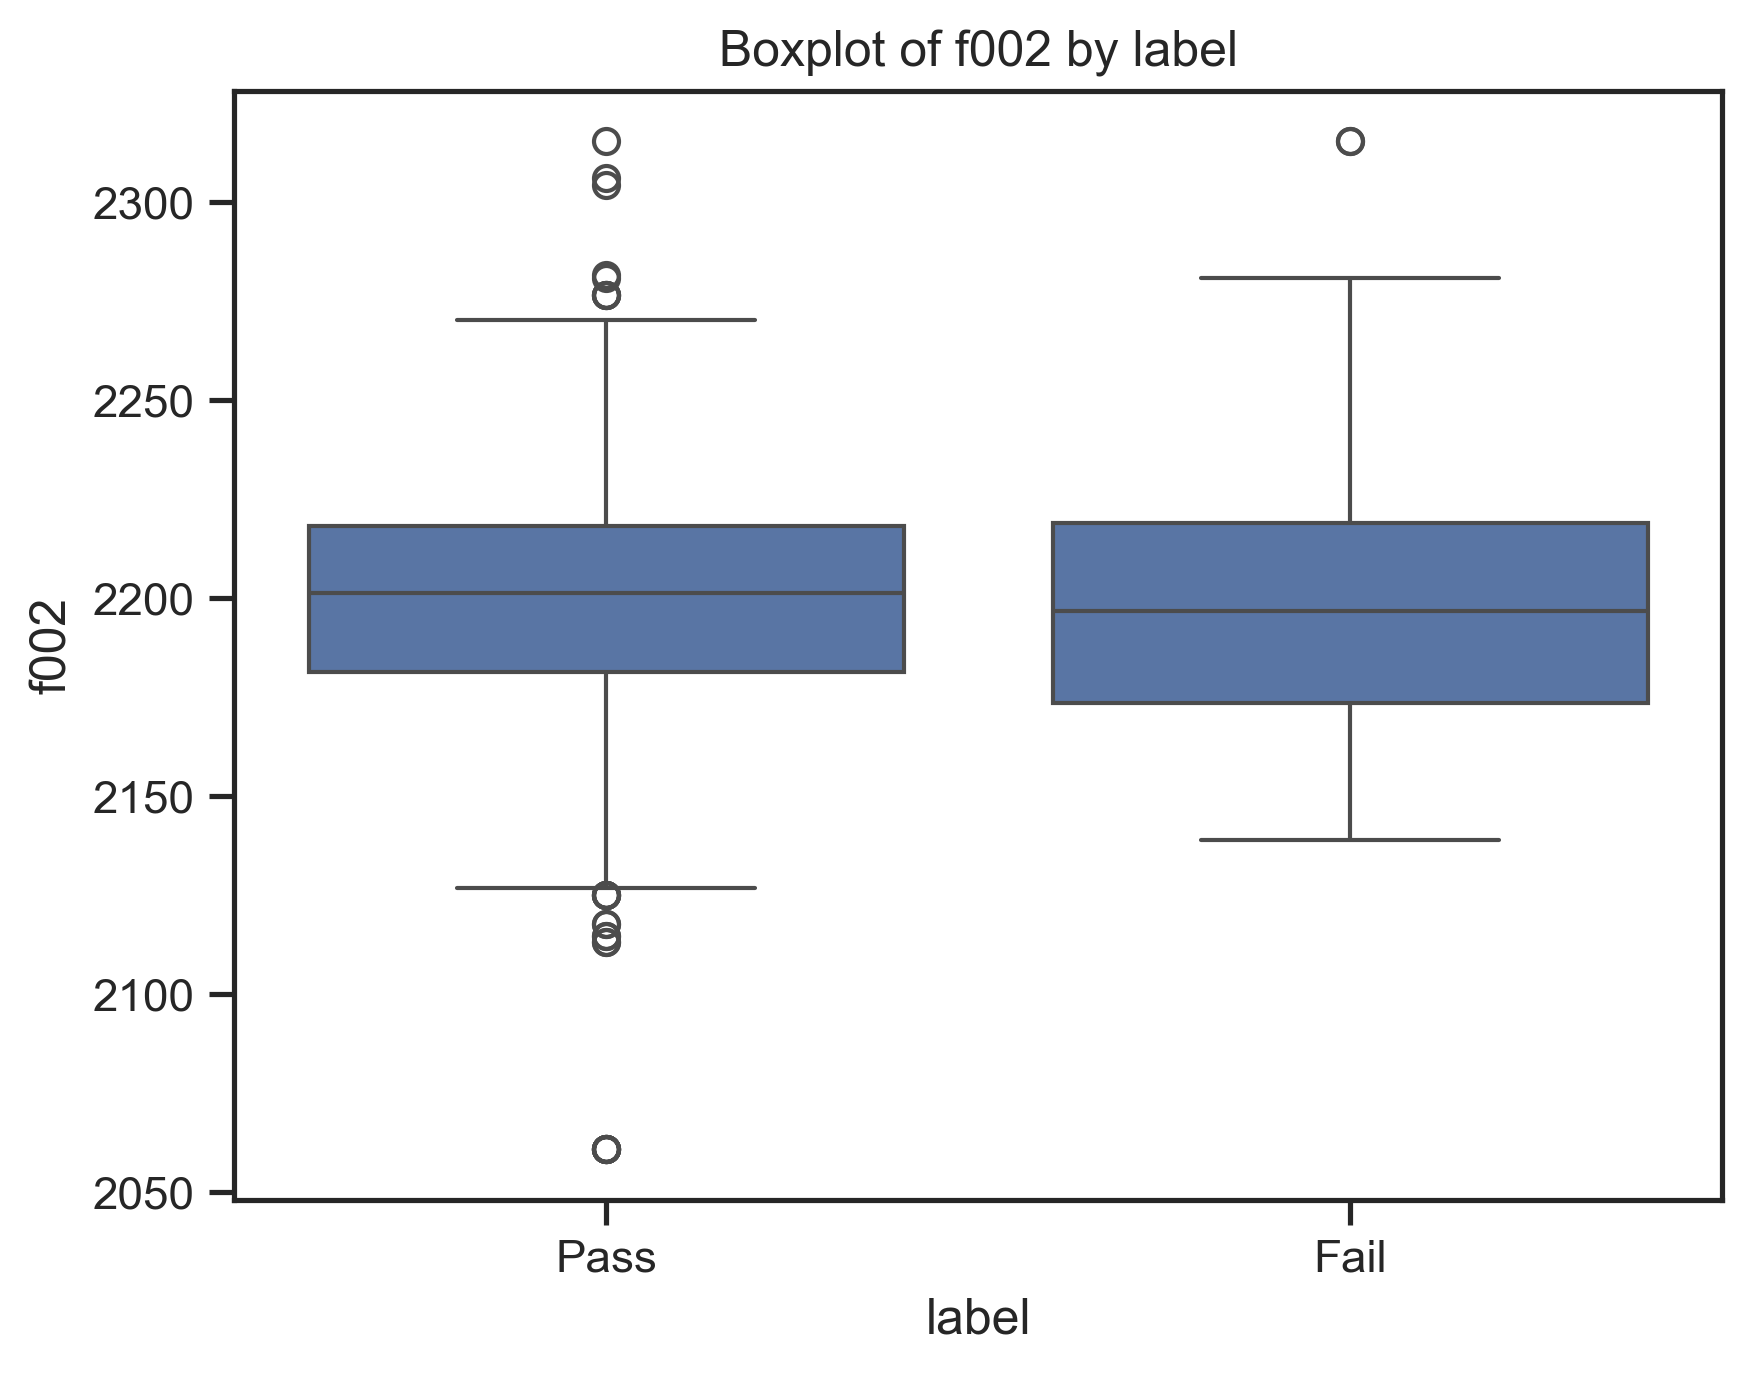

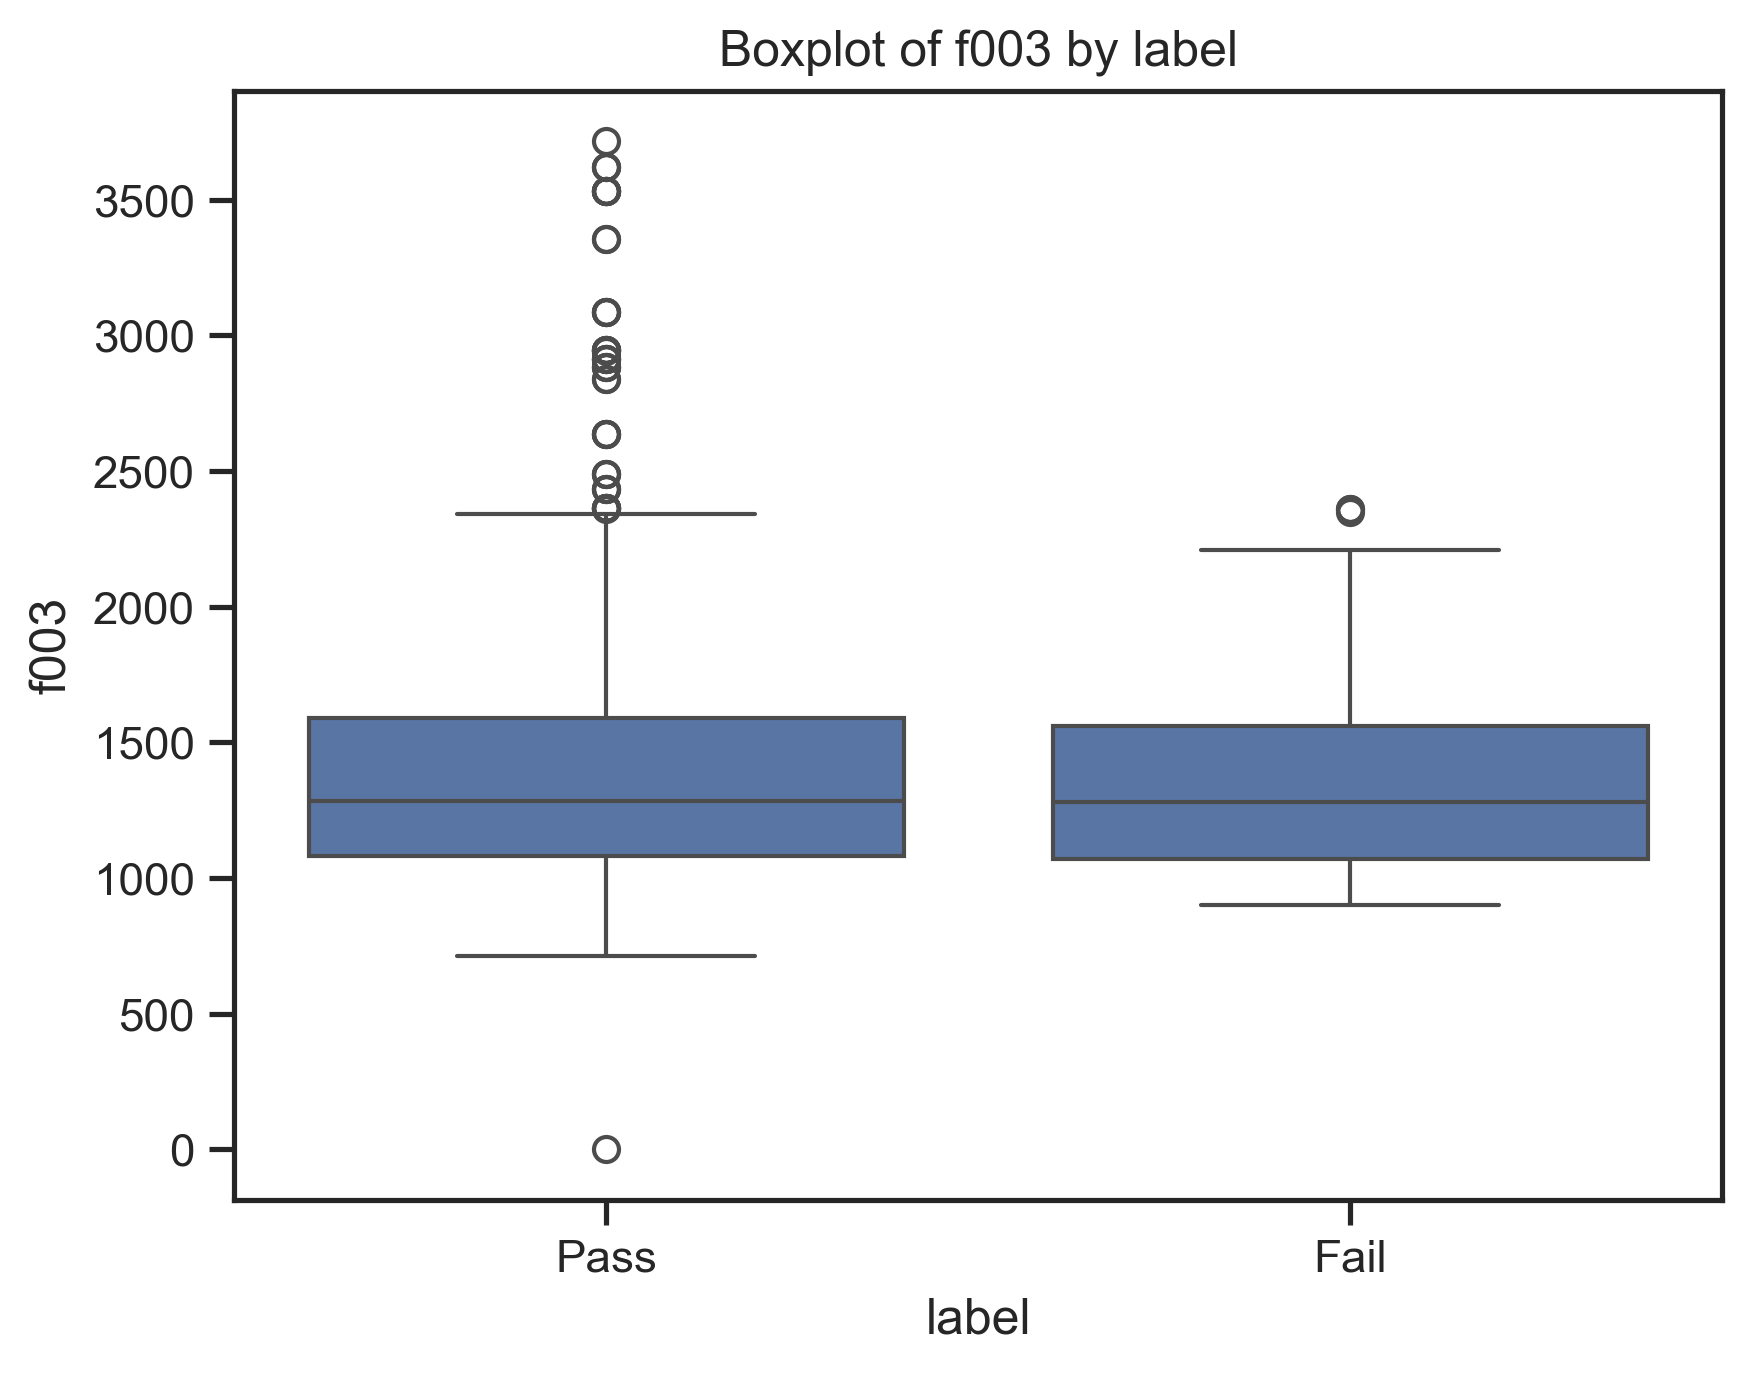

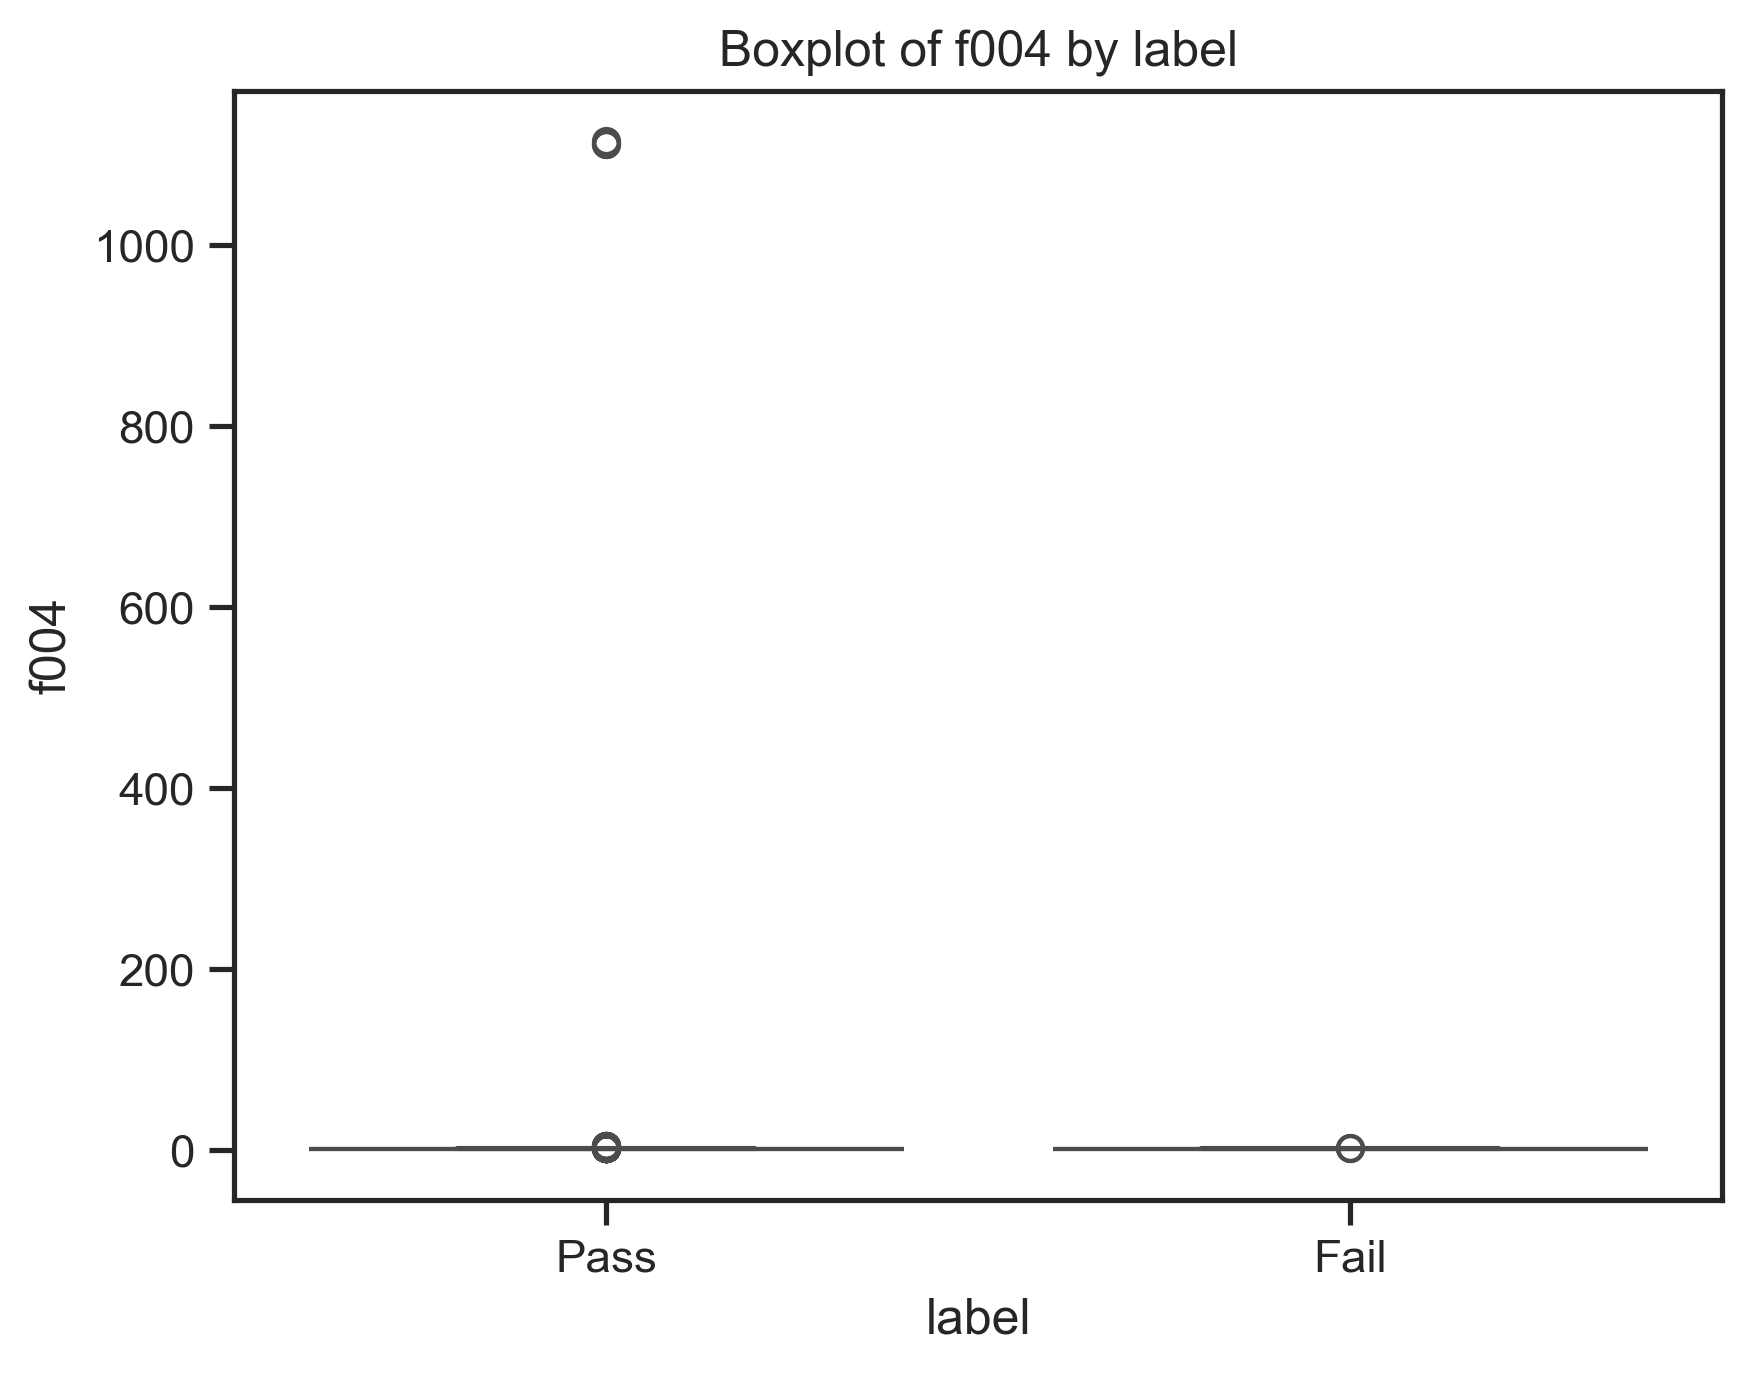

In [22]:
for col in sample_cols:
    ax = sns.boxplot(x="label", y=col, data=df)
    plt.title(f"Boxplot of {col} by label")
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(["Pass", "Fail"])
    plt.show()

#### **Insight and comparision:** First five features
#### Comparing KDE (distribution curves) vs Boxplots
1.	f000
	- KDE curve: Shift between Pass and Fail groups — fails are slightly shifted right (higher values).
	- Boxplot: Confirms median is slightly lower for Pass, Fail distribution has fewer outliers.
    - **Conclusion: This feature has some discriminative power.**
2.	f001
	- KDE curve: Almost identical curves for Pass and Fail.
	- Boxplot: Medians and IQR nearly overlapping.
   	- **Conclusion: Likely uninformative — does not help separate labels.**
3.	f002
	- KDE curve: Some separation (fail shifted slightly left).
	- Boxplot: Medians differ modestly, but overlapping IQR.
   	- **Conclusion: Mildly informative, could combine with others.**
4.	f003
	- KDE curve: Broad overlap, Pass wider spread. Fail distribution slightly tighter.
	- Boxplot: Many outliers in Pass, less in Fail.
   - **Conclusion: Might indicate process instability in Pass runs.**
5.	f004
	- KDE curve: Almost all values clustered near 0 --> sparse feature.
	- Boxplot: Both labels nearly flat, dominated by outliers.
   	- **Conclusion: Candidate for removal or imputation.**

### 4.5. Correlation structure

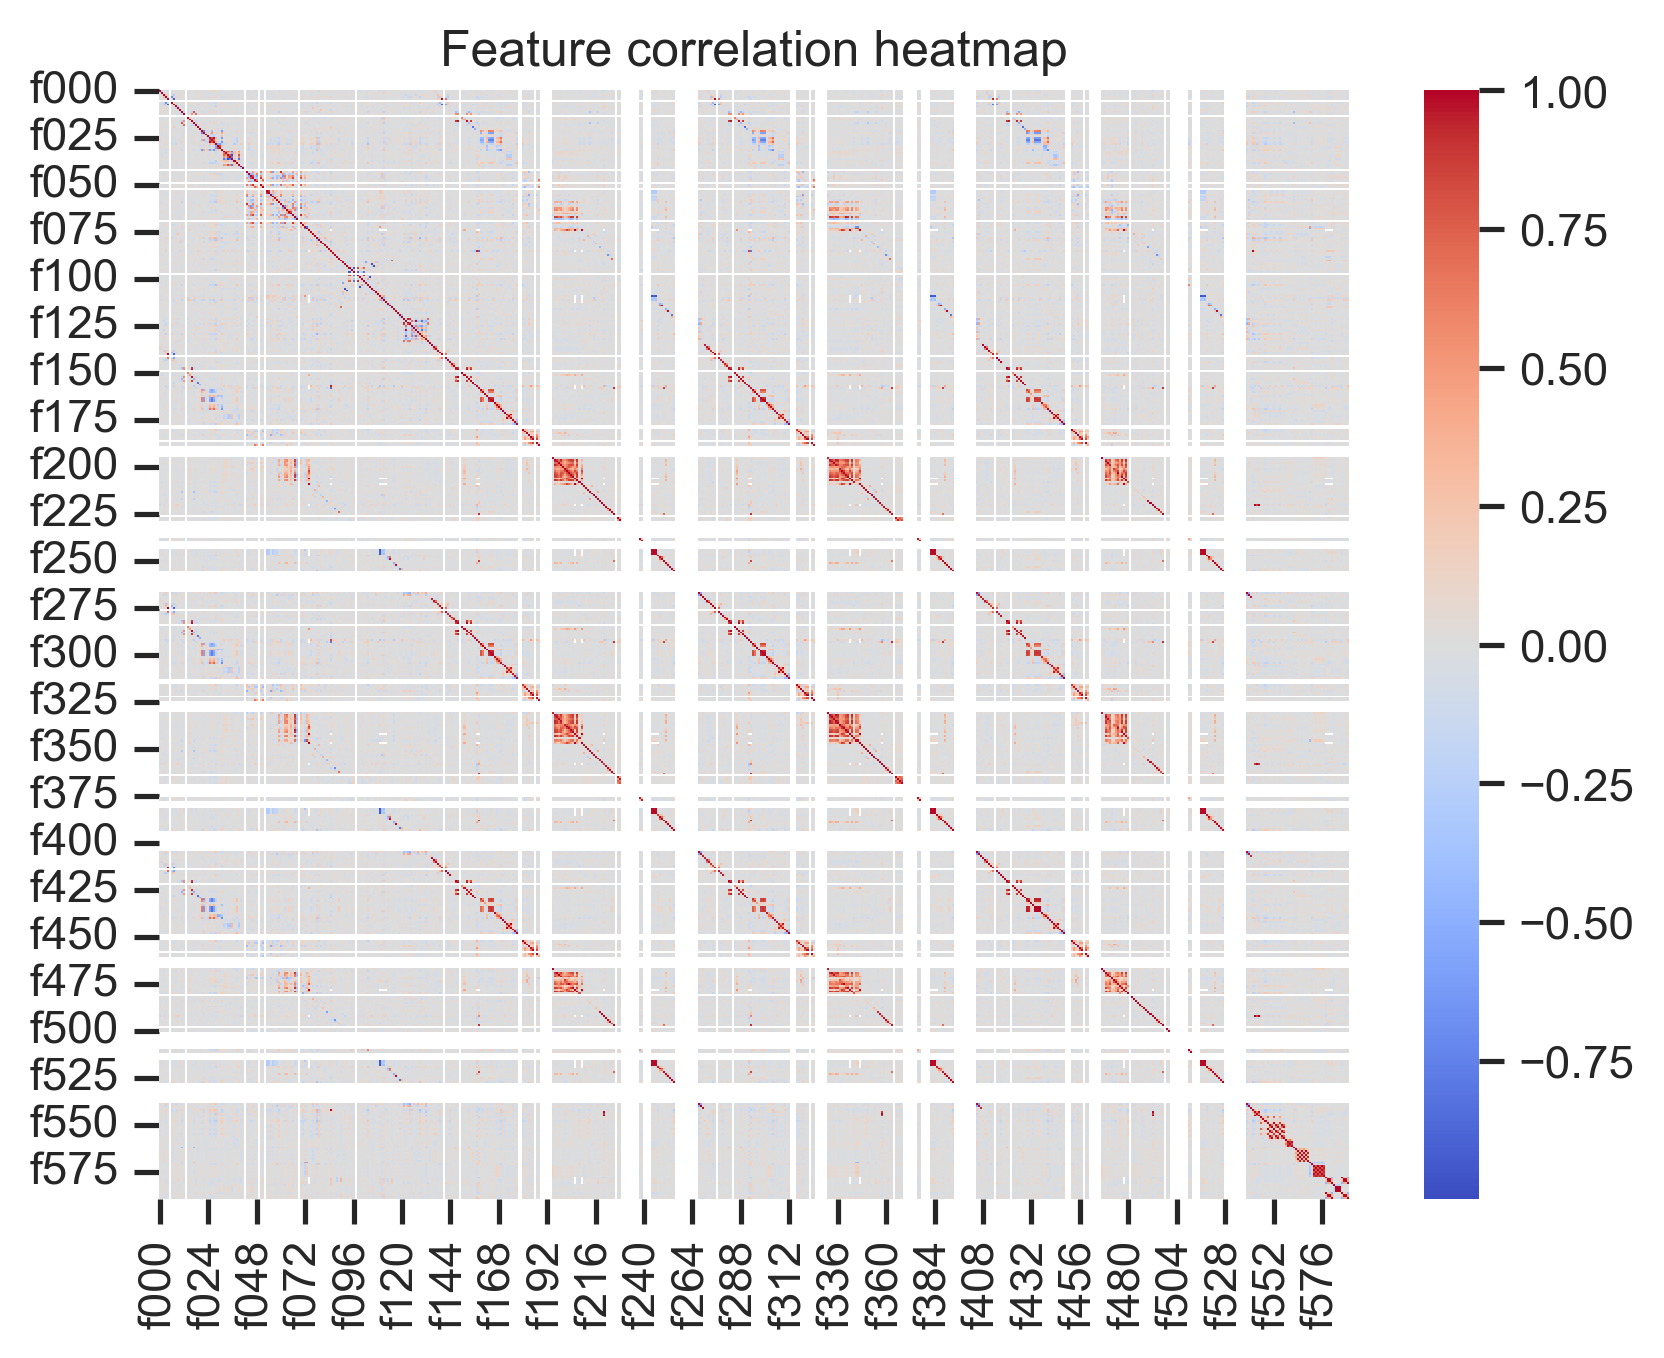

In [23]:
corr = df.drop(columns=["label", "timestamp"]).corr()

#plt.figure(figsize=(10,8))
sns.heatmap(corr.iloc[:,:], cmap="coolwarm", center=0)  # subset 30x30 to avoid clutter
plt.title("Feature correlation heatmap")
plt.show()

#### **Insight:** The correlation heatmap reveals that many `SECOM` sensor features form small, highly correlated clusters, suggesting redundancy. Most features, however, show weak or no correlation, consistent with the dataset’s high dimensionality. This supports the need for dimensionality reduction (e.g., PCA) or feature selection before modeling.

### 4.6. Variance by feature

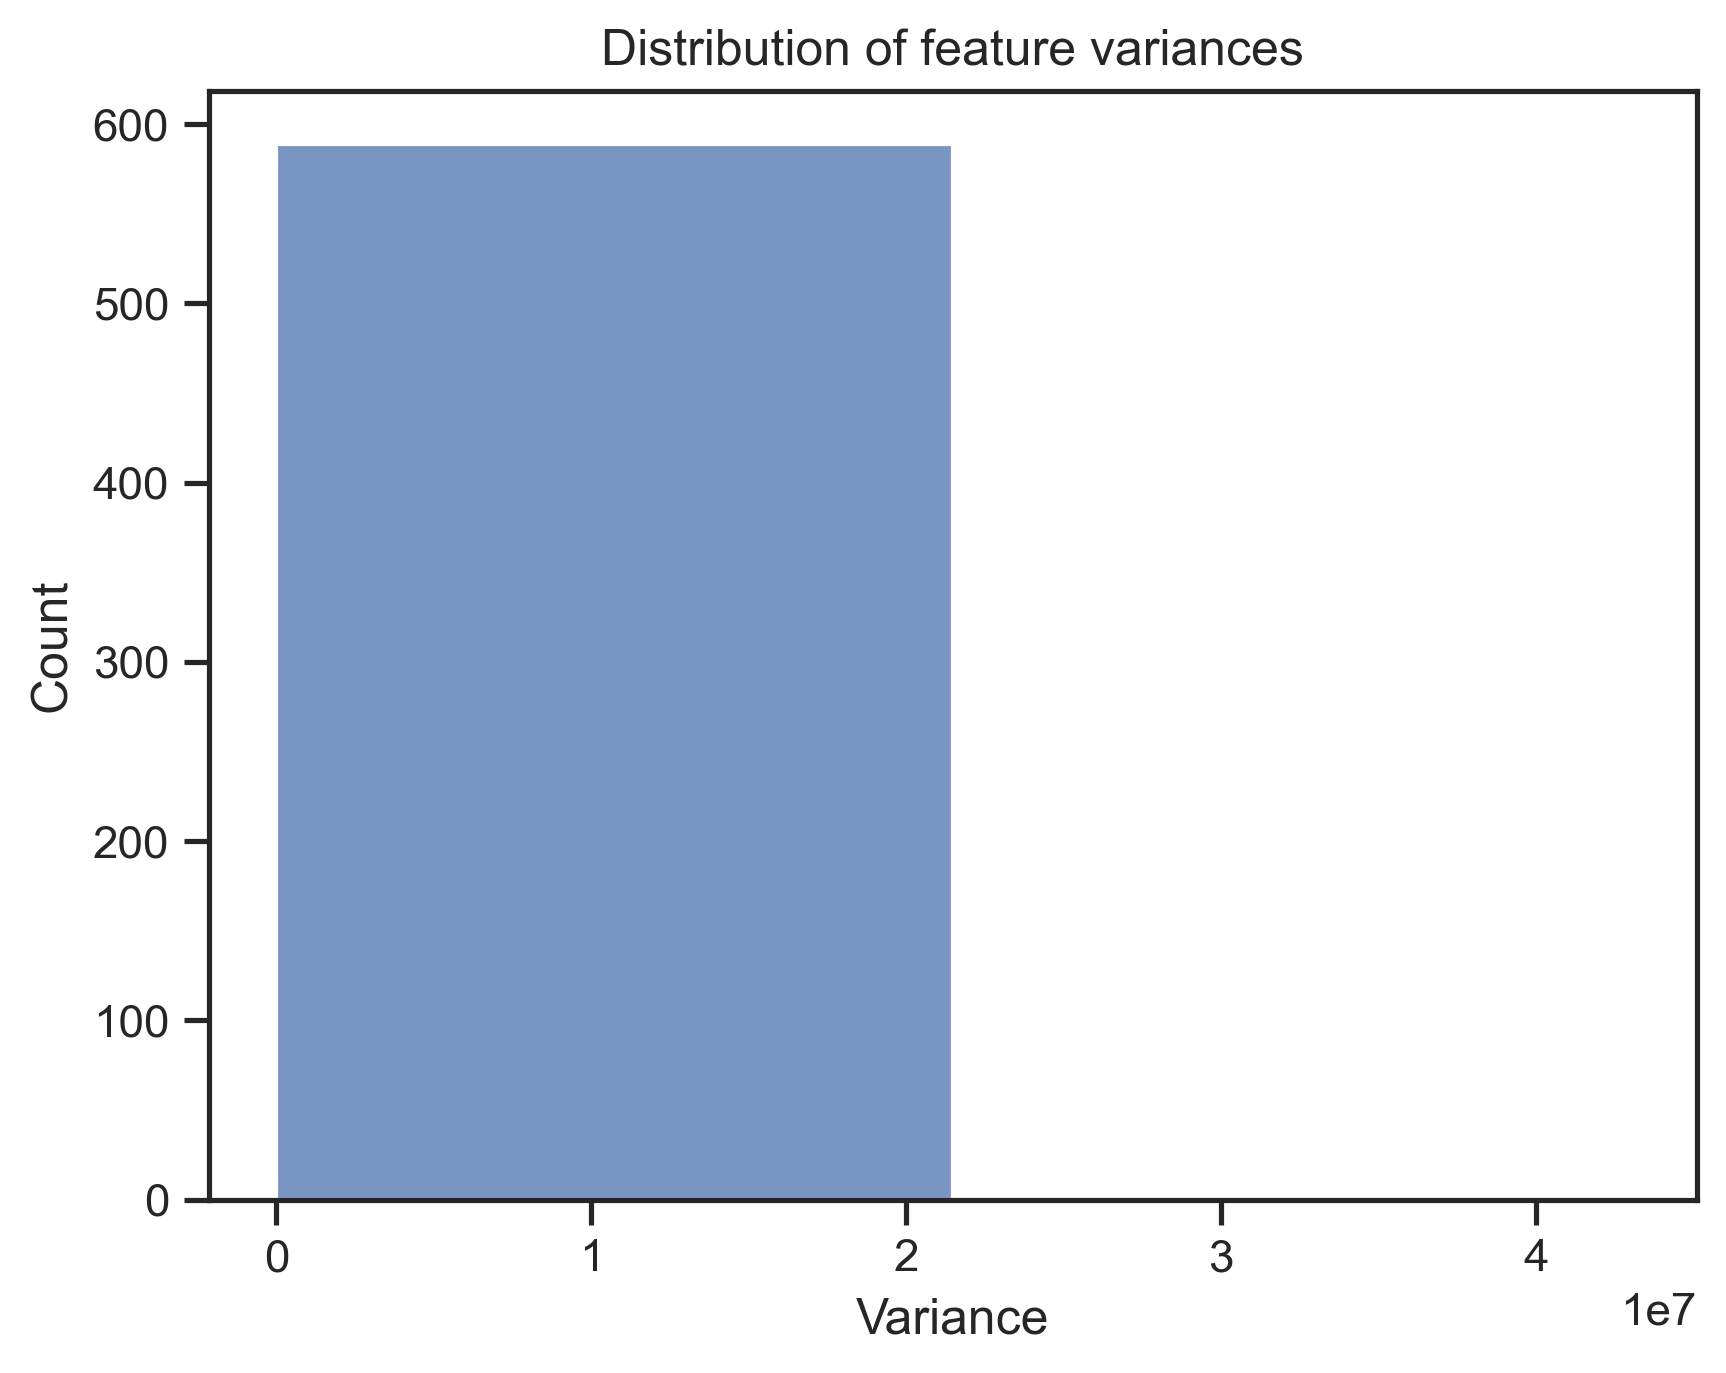

In [24]:
variances = df.drop(columns=["label", "timestamp"]).var()
sns.histplot(variances, bins=2)
plt.xlabel("Variance")
plt.title("Distribution of feature variances")
plt.show()

#### **Insight:** The variance distribution shows that most SECOM features have minimal variability, while a small set of sensors exhibit extremely high variance. This imbalance highlights the need for standardization and possibly filtering out near-constant features, since they contribute little to distinguishing pass/fail lots.

### 4.7. Dimensionality check (PCA visualization)

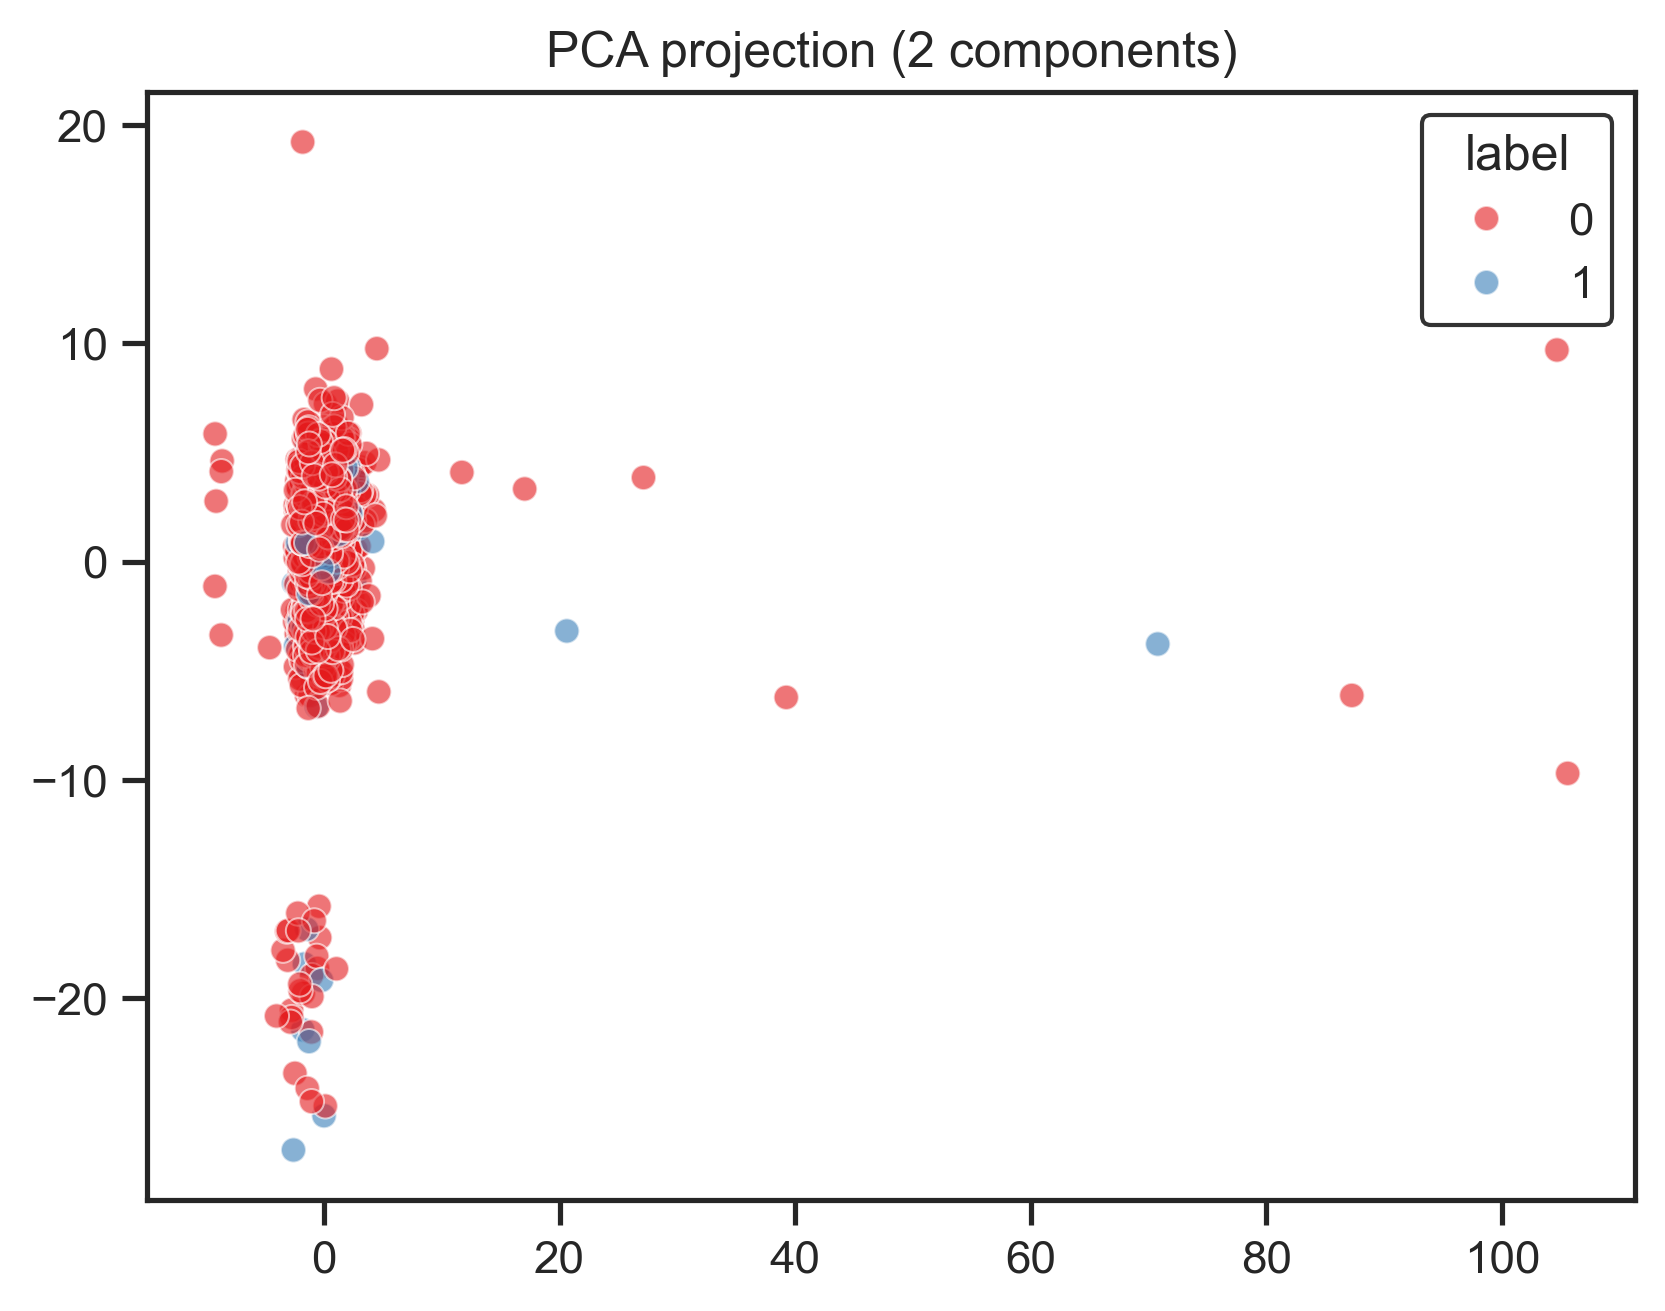

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_scaled = sc.fit_transform(df.drop(columns=["label", "timestamp"]).fillna(0))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["label"], alpha=0.6, palette="Set1")
plt.title("PCA projection (2 components)")
plt.show()

#### **Insight:** The first two PCs (max variance directions) do not separate the labels. This means:
- The class imbalance problem is verified.
- Failure patterns are likely subtle, nonlinear, or hidden in higher dimensions.
- Simple linear models or PCA-only reductions will struggle.

>The PCA scatterplot (first two principal components) highlights the overall structure of the SECOM dataset. The majority of Pass runs (red) form a dense cluster near the origin, while Fail runs (blue) are scattered throughout the same region without forming a distinct cluster. This strong overlap indicates that the dominant variance in the dataset is not associated with the Pass/Fail outcome. Moreover, Fail observations appear heterogeneous — distributed across multiple sub-regions rather than concentrated in a single failure mode. A few extreme points along the first component suggest potential outliers, which may represent abnormal runs or noise.

>Overall, this visualization illustrates why simple linear or variance-based approaches struggle with SECOM: the separation between Pass and Fail is subtle, nonlinear, and likely embedded in higher-dimensional structure. This reinforces the need for advanced modeling strategies such as neural networks, ensemble methods, or anomaly detection approaches to capture the rare and heterogeneous failure patterns.

In [26]:
df.head()

,f000,f001,f002,f003,f004,f005,f006,f007,f008,f009,...,f582,f583,f584,f585,f586,f587,f588,f589,label,timestamp
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 15:22:00


In [29]:
EDA = Path(DATA_DIR/"interim")
EDA.mkdir(parents=True, exist_ok=True)

df.to_parquet(EDA/"SECOM_EDA.parquet", index=False)

#### EDA Conlcusion:
The exploratory analysis of the SECOM dataset reveals several key challenges that explain why this problem is notoriously difficult:
- Severe class imbalance: Only ~6.6% of runs are labeled as Fail, with the vast majority (~93.4%) labeled as Pass. This imbalance means that naïve models can achieve high accuracy by always predicting Pass, but completely fail to capture the rare and critical failures.
- Missing values: Many sensors exhibit missing data, with a long-tailed distribution. While most features have very few missing entries, some sensors have >90% missing values, making them unreliable. This indicates the need for robust imputation strategies and possibly discarding features that contribute little usable information.
- Feature variance: A large proportion of sensors show extremely low variance, suggesting redundancy or inactivity. These features are unlikely to help distinguish failures from normal runs and add noise to the modeling process.
- Outliers: Boxplots reveal substantial outliers across multiple sensors, particularly in Pass runs. These may represent process noise, sensor malfunctions, or unrecorded operating conditions, complicating the distinction between normal and abnormal runs.
- Correlation structure: The correlation heatmap shows clusters of highly correlated sensors, which is expected in semiconductor processes where groups of sensors monitor related stages. However, this redundancy increases dimensionality without necessarily improving predictive power, reinforcing the need for dimensionality reduction or feature selection.
- Pass vs. Fail distributions: When comparing sensor distributions across labels, most features show strong overlap between Pass and Fail, with only subtle shifts in means or tails. This confirms that no single sensor is individually predictive of failure — discriminative signals are likely buried in multivariate, nonlinear interactions.
- PCA visualization: A projection into two principal components highlights dense clustering of Pass runs with Fail runs dispersed within the same regions. The lack of clear separation reinforces that dominant variance in the dataset is not aligned with Pass/Fail labels, and that failures may correspond to multiple heterogeneous patterns.

#### EDA Summary
>The SECOM dataset is highly imbalanced (~6.6% fails), with many missing values, low-variance sensors, and substantial outliers. Most sensor distributions show strong overlap between Pass and Fail, and PCA confirms that failures do not form distinct clusters. This indicates that no single sensor is predictive of failure; useful signals lie in multivariate, nonlinear interactions. Overall, SECOM represents a noisy, high-dimensional, and subtle anomaly detection challenge, requiring robust preprocessing and advanced modeling beyond standard classifiers.